In [2]:
import numpy as np
import pandas as pd
import os
import pickle
from bs4 import BeautifulSoup
import nltk

# for training and prediction
from sklearn import model_selection
#from sklearn.ensemble import RandomForestClassifier

# for calculating similarities among text
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from gensim import corpora, models, similarities

In [3]:
# load the data
col_types = {'Id': 'int', 
             'OwnerUserId': 'float', 
             'CreationDate': 'str', 
             'ParentId': 'int', 
             'Score': 'int',
             'Title': 'str',
             'Body':'str'}

questions = pd.read_csv('Questions.csv', encoding = "latin-1",engine='python')
answers = pd.read_csv('Answers.csv', encoding = "latin-1",engine='python')

In [ ]:
# dataset and pre-stored object files
# print(os.listdir("../input/pythonquestions"))
# print(os.listdir("../input/object-files-for-computed-matrices"))

In [2]:
# Functions for save and load derived data objects
def save_obj(obj, fpath):
    with open(fpath, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(fpath):
    if os.path.exists(fpath):
        with open(fpath, 'rb') as f:
            return pickle.load(f)
    else:
        return None

In [15]:
# question to answer: (ans_id, score, owner_id)
q_to_a = load_obj('../input/object-files-for-computed-matrices/q_to_a.pkl')
if not q_to_a:
    q_to_a = dict()
    for _, row in answers[['Id', 'ParentId', 'Score', 'OwnerUserId']].iterrows():
        q_id = row['ParentId']
        a_id = row['Id']
        a_score = row['Score']
        a_owner_id = row['OwnerUserId'] if not np.isnan(row['OwnerUserId']) else None
        if q_id not in q_to_a:
            q_to_a[q_id] = [(a_id, a_score, a_owner_id)]
        else:
            q_to_a[q_id].append((a_id, a_score, a_owner_id))
            
    save_obj(q_to_a, 'q_to_a.pkl')

# Keep only the questions with 4-10 answers and a distinguishable answer
q_to_a = {k:v for k, v in q_to_a.items() if len(v)>3 and len(v)<11 and max(v, key=lambda x: x[1])[1]>0}
    
# keep only qualified questions
questions_new = questions[questions['Id'].isin(q_to_a)]

In [22]:
# Keep only answers related to a qualified question
def answer_in_use(answer):
    if answer['ParentId'] in q_to_a:
        for item in q_to_a[answer['ParentId']]:
            if answer['Id'] == item[0]:
                return True
    return False

answers_new = answers[answers.apply(lambda x: answer_in_use(x), axis=1)]

In [20]:
questions.head(n=50)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...
5,330,63.0,2008-08-02T02:51:36Z,NaN,29,Should I use nested classes in this case?,<p>I am working on a collection of classes use...
6,470,71.0,2008-08-02T15:11:47Z,2016-03-26T05:23:29Z,13,Homegrown consumption of web services,<p>I've been writing a few web services for a ...
7,580,91.0,2008-08-02T23:30:59Z,NaN,21,Deploying SQL Server Databases from Test to Live,<p>I wonder how you guys manage deployment of ...
8,650,143.0,2008-08-03T11:12:52Z,NaN,79,Automatically update version number,<p>I would like the version property of my app...
9,810,233.0,2008-08-03T20:35:01Z,NaN,9,Visual Studio Setup Project - Per User Registr...,<p>I'm trying to maintain a Setup Project in <...


In [19]:
questions_new.head(n=50)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...
5,330,63.0,2008-08-02T02:51:36Z,NaN,29,Should I use nested classes in this case?,<p>I am working on a collection of classes use...
8,650,143.0,2008-08-03T11:12:52Z,NaN,79,Automatically update version number,<p>I would like the version property of my app...
9,810,233.0,2008-08-03T20:35:01Z,NaN,9,Visual Studio Setup Project - Per User Registr...,<p>I'm trying to maintain a Setup Project in <...
10,930,245.0,2008-08-04T00:47:25Z,NaN,28,How do I connect to a database and loop over a...,<p>What's the simplest way to connect and quer...
12,1040,254.0,2008-08-04T05:45:22Z,NaN,42,How do I delete a file which is locked by anot...,<p>I'm looking for a way to delete a file whic...
13,1070,236.0,2008-08-04T07:34:44Z,NaN,17,Process size on UNIX,<p>What is the correct way to get the process ...
15,1180,281.0,2008-08-04T12:22:07Z,NaN,17,How to make subdomain user accounts in a webapp,<p>I am looking to allow users to control of s...
16,1300,91.0,2008-08-04T14:55:04Z,NaN,23,Is nAnt still supported and suitable for .net ...,<p>I am using MSBuild to build my stuff. I wan...


In [23]:
answers.head(n=50)

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,92,61.0,2008-08-01T14:45:37Z,90,13,"<p><a href=""http://svnbook.red-bean.com/"">Vers..."
1,124,26.0,2008-08-01T16:09:47Z,80,12,<p>I wound up using this. It is a kind of a ha...
2,199,50.0,2008-08-01T19:36:46Z,180,1,<p>I've read somewhere the human eye can't dis...
3,269,91.0,2008-08-01T23:49:57Z,260,4,"<p>Yes, I thought about that, but I soon figur..."
4,307,49.0,2008-08-02T01:49:46Z,260,28,"<p><a href=""http://www.codeproject.com/Article..."
5,332,59.0,2008-08-02T03:00:24Z,330,19,<p>I would be a bit reluctant to use nested cl...
6,344,100.0,2008-08-02T04:18:15Z,260,6,<p>You might be able to use IronRuby for that....
7,359,119.0,2008-08-02T06:16:23Z,260,5,"<P>You could use any of the DLR languages, whi..."
8,473,49.0,2008-08-02T15:33:13Z,470,8,"<p>No, what you're doing is fine. Don't let th..."
9,529,86.0,2008-08-02T18:16:07Z,180,3,<p>Isn't it also a factor which order you set ...


In [24]:
answers_new.head(n=50)

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
2,199,50.0,2008-08-01T19:36:46Z,180,1,<p>I've read somewhere the human eye can't dis...
3,269,91.0,2008-08-01T23:49:57Z,260,4,"<p>Yes, I thought about that, but I soon figur..."
4,307,49.0,2008-08-02T01:49:46Z,260,28,"<p><a href=""http://www.codeproject.com/Article..."
5,332,59.0,2008-08-02T03:00:24Z,330,19,<p>I would be a bit reluctant to use nested cl...
6,344,100.0,2008-08-02T04:18:15Z,260,6,<p>You might be able to use IronRuby for that....
7,359,119.0,2008-08-02T06:16:23Z,260,5,"<P>You could use any of the DLR languages, whi..."
9,529,86.0,2008-08-02T18:16:07Z,180,3,<p>Isn't it also a factor which order you set ...
10,539,157.0,2008-08-02T19:03:52Z,180,21,"<p>My first thought on this is ""how generate N..."
16,655,91.0,2008-08-03T11:41:38Z,650,69,"<p>With the ""Built in"" stuff, you can't, as us..."
17,787,175.0,2008-08-03T18:46:33Z,650,4,<p>What source control system are you using? <...


In [16]:
questions_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86966 entries, 3 to 1263944
Data columns (total 7 columns):
Id              86966 non-null int64
OwnerUserId     84892 non-null float64
CreationDate    86966 non-null object
ClosedDate      5215 non-null object
Score           86966 non-null int64
Title           86966 non-null object
Body            86966 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 5.3+ MB


In [17]:
questions.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 7 columns):
Id              1264216 non-null int64
OwnerUserId     1249762 non-null float64
CreationDate    1264216 non-null object
ClosedDate      55959 non-null object
Score           1264216 non-null int64
Title           1264216 non-null object
Body            1264216 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 67.5+ MB


In [4]:
answers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2014516 entries, 0 to 2014515
Data columns (total 6 columns):
Id              int64
OwnerUserId     float64
CreationDate    object
ParentId        int64
Score           int64
Body            object
dtypes: float64(1), int64(3), object(2)
memory usage: 92.2+ MB


In [26]:
answers_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428187 entries, 2 to 2014510
Data columns (total 7 columns):
Id                 428187 non-null int64
OwnerUserId        423905 non-null float64
CreationDate       428187 non-null object
ParentId           428187 non-null int64
Score              428187 non-null int64
Body               428187 non-null object
BodyEnglishText    428187 non-null object
dtypes: float64(1), int64(3), object(3)
memory usage: 26.1+ MB


In [27]:
def strip_code(html):
    bs = BeautifulSoup(html, 'html.parser')
    [s.extract() for s in bs('code')]
    return bs.get_text()

answers_new = answers_new.assign(BodyEnglishText = answers_new['Body'].apply(strip_code))
answers_new = answers_new.assign(EnglishCount = answers_new['BodyEnglishText'].apply(lambda x: len(x.split())))

In [28]:
answers_new.to_csv("answers_new.csv")

In [29]:
answers_new.head(n=50)

,Id,OwnerUserId,CreationDate,ParentId,Score,Body,BodyEnglishText,EnglishCount
2,199,50.0,2008-08-01T19:36:46Z,180,1,<p>I've read somewhere the human eye can't dis...,I've read somewhere the human eye can't distin...,115
3,269,91.0,2008-08-01T23:49:57Z,260,4,"<p>Yes, I thought about that, but I soon figur...","Yes, I thought about that, but I soon figured ...",162
4,307,49.0,2008-08-02T01:49:46Z,260,28,"<p><a href=""http://www.codeproject.com/Article...",Oleg Shilo's C# Script solution (at The Code P...,136
5,332,59.0,2008-08-02T03:00:24Z,330,19,<p>I would be a bit reluctant to use nested cl...,I would be a bit reluctant to use nested class...,129
6,344,100.0,2008-08-02T04:18:15Z,260,6,<p>You might be able to use IronRuby for that....,You might be able to use IronRuby for that. \n...,73
7,359,119.0,2008-08-02T06:16:23Z,260,5,"<P>You could use any of the DLR languages, whi...","You could use any of the DLR languages, which ...",63
9,529,86.0,2008-08-02T18:16:07Z,180,3,<p>Isn't it also a factor which order you set ...,Isn't it also a factor which order you set up ...,54
10,539,157.0,2008-08-02T19:03:52Z,180,21,"<p>My first thought on this is ""how generate N...","My first thought on this is ""how generate N ve...",183
16,655,91.0,2008-08-03T11:41:38Z,650,69,"<p>With the ""Built in"" stuff, you can't, as us...","With the ""Built in"" stuff, you can't, as using...",165
17,787,175.0,2008-08-03T18:46:33Z,650,4,<p>What source control system are you using? <...,What source control system are you using? \nAl...,56


In [30]:
def count_links(html):
    bs = BeautifulSoup(html, 'html.parser')
    return len(bs.find_all('a'))

answers_new = answers_new.assign(LinkCount = answers_new['Body'].apply(count_links))

In [31]:
def code_length(html):
    bs = BeautifulSoup(html, 'html.parser')
    contents = [tag.text.split() for tag in bs.find_all('code')]
    return sum(len(item) for item in contents)

answers_new = answers_new.assign(CodeLength = answers_new['Body'].apply(code_length))
answers_new = answers_new.assign(TotalLength = answers_new.apply(lambda row: row['EnglishCount'] + row['CodeLength'], axis=1))

In [32]:
def get_order(qid, aid):
    ids = [i[0] for i in q_to_a[qid]]
    return ids.index(aid)+1

answers_new = answers_new.assign(PostOrder = answers_new.apply(lambda row: get_order(row['ParentId'], row['Id']), axis=1))


In [33]:
answers_new.to_csv("answers_new_withnums.csv")

In [34]:
# calculate reputation scores for users
user_rep = dict()
for ans_list in q_to_a.values():
    for _, score, owner_id in ans_list:
        if owner_id:
            if owner_id in user_rep:
                user_rep[owner_id] += score
            else:
                user_rep[owner_id] = score

In [35]:
def get_reputation(userId):
    if not np.isnan(userId) and userId in user_rep:
        return user_rep[userId]
    else:
        return 0

answers_new = answers_new.assign(Reputation = answers_new['OwnerUserId'].apply(get_reputation))

In [36]:
answers_new.head(10)

,Id,OwnerUserId,CreationDate,ParentId,Score,Body,BodyEnglishText,EnglishCount,LinkCount,CodeLength,TotalLength,PostOrder,Reputation
2,199,50.0,2008-08-01T19:36:46Z,180,1,<p>I've read somewhere the human eye can't dis...,I've read somewhere the human eye can't distin...,115,0,109,224,1,4.0
3,269,91.0,2008-08-01T23:49:57Z,260,4,"<p>Yes, I thought about that, but I soon figur...","Yes, I thought about that, but I soon figured ...",162,0,0,162,1,373.0
4,307,49.0,2008-08-02T01:49:46Z,260,28,"<p><a href=""http://www.codeproject.com/Article...",Oleg Shilo's C# Script solution (at The Code P...,136,8,0,136,2,61.0
5,332,59.0,2008-08-02T03:00:24Z,330,19,<p>I would be a bit reluctant to use nested cl...,I would be a bit reluctant to use nested class...,129,1,0,129,1,20.0
6,344,100.0,2008-08-02T04:18:15Z,260,6,<p>You might be able to use IronRuby for that....,You might be able to use IronRuby for that. \n...,73,1,0,73,3,7.0
7,359,119.0,2008-08-02T06:16:23Z,260,5,"<P>You could use any of the DLR languages, whi...","You could use any of the DLR languages, which ...",63,0,0,63,4,5.0
9,529,86.0,2008-08-02T18:16:07Z,180,3,<p>Isn't it also a factor which order you set ...,Isn't it also a factor which order you set up ...,54,0,0,54,2,10.0
10,539,157.0,2008-08-02T19:03:52Z,180,21,"<p>My first thought on this is ""how generate N...","My first thought on this is ""how generate N ve...",183,2,0,183,3,37.0
16,655,91.0,2008-08-03T11:41:38Z,650,69,"<p>With the ""Built in"" stuff, you can't, as us...","With the ""Built in"" stuff, you can't, as using...",165,4,16,181,1,373.0
17,787,175.0,2008-08-03T18:46:33Z,650,4,<p>What source control system are you using? <...,What source control system are you using? \nAl...,56,0,0,56,2,4.0


In [37]:
answers_new.to_csv("answers_new_withnums.csv")

In [39]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/zs2390/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def compute_sim(q_to_a, df_questions, df_answers):
    a_sim = dict()
    tokenizer = RegexpTokenizer(r'\w+')
    print(len(q_to_a))
    c = 0
    for q_id, a_list in q_to_a.items():
        # show progress
        c+=1
        print(str(c) + ' ' + str(len(a_list)), end='\r')
        
        # get split body text for a question and the answers
        q_body = df_questions[df_questions['Id']==q_id].iloc[0]['Body']
        q_body = BeautifulSoup(q_body, 'html.parser').get_text()#.split()
        q_body = tokenizer.tokenize(q_body.lower())
        q_body = [w for w in q_body if w not in stopwords.words('english')]
        
        a_bodies = list()
        for a_id, _, _ in a_list:
            a_body = df_answers[df_answers['Id']==a_id].iloc[0]['Body']
            a_body = BeautifulSoup(a_body, 'html.parser').get_text()#.split()
            a_body = tokenizer.tokenize(a_body.lower())
            a_body = [w for w in a_body if w not in stopwords.words('english')]
            a_bodies.append(a_body)
        
        # apply a series of transformations to the answers: bag-of-word, tf-idf, and lsi
        dictionary = corpora.Dictionary(a_bodies)
        corpus = [dictionary.doc2bow(a) for a in a_bodies]
        tfidf = models.TfidfModel(corpus)
        corpus_tfidf = tfidf[corpus]
        lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=4)
        corpus_lsi = lsi[corpus_tfidf]
        
        index = similarities.MatrixSimilarity(corpus_lsi)
        # question-to-answer similarity
        q_bow = dictionary.doc2bow(q_body)
        q_lsi = lsi[q_bow]
        q_to_a_sim = index[q_lsi]
        
        # ans-to-ans similarity, excluding the answer itself
        for idx, a_lsi in enumerate(corpus_lsi):
            a_to_a_sim = index[a_lsi]
            a_to_a_sim = [a_to_a_sim[i] for i in range(len(a_to_a_sim)) if i != idx]  # exclude itself
            
            # construct the dictionary a_sim
            a_id = a_list[idx][0]
            sim_to_q = q_to_a_sim[idx]
            max_sim_to_a = max(a_to_a_sim)
            min_sim_to_a = min(a_to_a_sim)
            a_sim[a_id] = (sim_to_q, max_sim_to_a, min_sim_to_a)
    
    return a_sim
a_sim = load_obj('../input/object-files-for-computed-matrices/a_sim.pkl')
if not a_sim:
    a_sim = compute_sim(q_to_a, questions, answers)
    save_obj(a_sim, '../input/object-files-for-computed-matrices/a_sim.pkl')

In [41]:
save_obj(a_sim, 'a_sim.pkl')

In [42]:
answers_new = answers_new.assign(SimToQ = answers_new['Id'].apply(lambda a_id: a_sim[a_id][0]))
answers_new = answers_new.assign(MaxSimToA = answers_new['Id'].apply(lambda a_id: a_sim[a_id][1]))
answers_new = answers_new.assign(MinSimToA = answers_new['Id'].apply(lambda a_id: a_sim[a_id][2]))
#answers.head(3)
answers_new.to_csv("answers_new_allcols.csv")

In [6]:
answers_new.head(10)

,Unnamed: 0,Id,OwnerUserId,CreationDate,ParentId,Score,Body,BodyEnglishText,EnglishCount,LinkCount,CodeLength,TotalLength,PostOrder,Reputation,SimToQ,MaxSimToA,MinSimToA
0,2,199,50.0,2008-08-01T19:36:46Z,180,1,<p>I've read somewhere the human eye can't dis...,I've read somewhere the human eye can't distin...,115,0,109,224,1,4.0,0.781664,0.771909,-0.303940
1,3,269,91.0,2008-08-01T23:49:57Z,260,4,"<p>Yes, I thought about that, but I soon figur...","Yes, I thought about that, but I soon figured ...",162,0,0,162,1,373.0,0.785953,0.118875,-0.148410
2,4,307,49.0,2008-08-02T01:49:46Z,260,28,"<p><a href=""http://www.codeproject.com/Article...",Oleg Shilo's C# Script solution (at The Code P...,136,8,0,136,2,61.0,0.464822,0.941471,-0.107907
3,5,332,59.0,2008-08-02T03:00:24Z,330,19,<p>I would be a bit reluctant to use nested cl...,I would be a bit reluctant to use nested class...,129,1,0,129,1,20.0,0.968646,0.758514,0.151453
4,6,344,100.0,2008-08-02T04:18:15Z,260,6,<p>You might be able to use IronRuby for that....,You might be able to use IronRuby for that. \n...,73,1,0,73,3,7.0,0.375845,0.923870,-0.362051
5,7,359,119.0,2008-08-02T06:16:23Z,260,5,"<P>You could use any of the DLR languages, whi...","You could use any of the DLR languages, which ...",63,0,0,63,4,5.0,0.532780,0.923870,-0.163140
6,9,529,86.0,2008-08-02T18:16:07Z,180,3,<p>Isn't it also a factor which order you set ...,Isn't it also a factor which order you set up ...,54,0,0,54,2,10.0,0.558718,0.524847,-0.503398
7,10,539,157.0,2008-08-02T19:03:52Z,180,21,"<p>My first thought on this is ""how generate N...","My first thought on this is ""how generate N ve...",183,2,0,183,3,37.0,0.847757,0.691793,-0.029897
8,16,655,91.0,2008-08-03T11:41:38Z,650,69,"<p>With the ""Built in"" stuff, you can't, as us...","With the ""Built in"" stuff, you can't, as using...",165,4,16,181,1,373.0,0.830584,0.967332,-0.171125
9,17,787,175.0,2008-08-03T18:46:33Z,650,4,<p>What source control system are you using? <...,What source control system are you using? \nAl...,56,0,0,56,2,4.0,0.385481,0.720575,-0.171125


In [ ]:
#dont run

#def is_answer(qid, aid):
#    if aid == max(q_to_a[qid], key=lambda item: item[1])[0]:
#        return 1
#    else:
#        return 0
    
#answers = answers.assign(IsAnswer = answers.apply(lambda row: is_answer(row['ParentId'], row['Id']), axis=1))
#answers.head(3)

In [ ]:
#q_train, q_test = model_selection.train_test_split(questions, test_size=0.2, random_state=42)

In [ ]:
#a_train = answers[answers['ParentId'].isin(q_train['Id'])]
#a_test = answers[answers['ParentId'].isin(q_test['Id'])]

In [7]:
#questions = pd.read_csv('Questions.csv', encoding = "latin-1",engine='python')
answers_new = pd.read_csv('answers_new_allcols.csv', encoding = "latin-1",engine='c')


In [4]:
from sklearn.linear_model import LinearRegression

In [5]:
answers_new = pd.DataFrame(answers_new, columns=['EnglishCount', 'LinkCount', 'CodeLength', 'TotalLength','PostOrder','Reputation','SimToQ'])

In [8]:
answers_new.head(n=10)

,Unnamed: 0,Id,OwnerUserId,CreationDate,ParentId,Score,Body,BodyEnglishText,EnglishCount,LinkCount,CodeLength,TotalLength,PostOrder,Reputation,SimToQ,MaxSimToA,MinSimToA
0,2,199,50.0,2008-08-01T19:36:46Z,180,1,<p>I've read somewhere the human eye can't dis...,I've read somewhere the human eye can't distin...,115,0,109,224,1,4.0,0.781664,0.771909,-0.303940
1,3,269,91.0,2008-08-01T23:49:57Z,260,4,"<p>Yes, I thought about that, but I soon figur...","Yes, I thought about that, but I soon figured ...",162,0,0,162,1,373.0,0.785953,0.118875,-0.148410
2,4,307,49.0,2008-08-02T01:49:46Z,260,28,"<p><a href=""http://www.codeproject.com/Article...",Oleg Shilo's C# Script solution (at The Code P...,136,8,0,136,2,61.0,0.464822,0.941471,-0.107907
3,5,332,59.0,2008-08-02T03:00:24Z,330,19,<p>I would be a bit reluctant to use nested cl...,I would be a bit reluctant to use nested class...,129,1,0,129,1,20.0,0.968646,0.758514,0.151453
4,6,344,100.0,2008-08-02T04:18:15Z,260,6,<p>You might be able to use IronRuby for that....,You might be able to use IronRuby for that. \n...,73,1,0,73,3,7.0,0.375845,0.923870,-0.362051
5,7,359,119.0,2008-08-02T06:16:23Z,260,5,"<P>You could use any of the DLR languages, whi...","You could use any of the DLR languages, which ...",63,0,0,63,4,5.0,0.532780,0.923870,-0.163140
6,9,529,86.0,2008-08-02T18:16:07Z,180,3,<p>Isn't it also a factor which order you set ...,Isn't it also a factor which order you set up ...,54,0,0,54,2,10.0,0.558718,0.524847,-0.503398
7,10,539,157.0,2008-08-02T19:03:52Z,180,21,"<p>My first thought on this is ""how generate N...","My first thought on this is ""how generate N ve...",183,2,0,183,3,37.0,0.847757,0.691793,-0.029897
8,16,655,91.0,2008-08-03T11:41:38Z,650,69,"<p>With the ""Built in"" stuff, you can't, as us...","With the ""Built in"" stuff, you can't, as using...",165,4,16,181,1,373.0,0.830584,0.967332,-0.171125
9,17,787,175.0,2008-08-03T18:46:33Z,650,4,<p>What source control system are you using? <...,What source control system are you using? \nAl...,56,0,0,56,2,4.0,0.385481,0.720575,-0.171125


In [59]:
#X.head(5)
Y = pd.DataFrame(answers_new,columns = ['Score'])

In [48]:
q_to_a = load_obj('q_to_a.pkl')
q_to_a = {k:v for k, v in q_to_a.items() if len(v)>3 and len(v)<11 and max(v, key=lambda x: x[1])[1]>0}
list(q_to_a)

[180.0,
 260.0,
 330.0,
 650.0,
 810.0,
 930.0,
 1040.0,
 1070.0,
 1180.0,
 1300.0,
 1390.0,
 1600.0,
 1610.0,
 1790.0,
 1970.0,
 2250.0,
 2300.0,
 2120.0,
 2540.0,
 2550.0,
 2750.0,
 2770.0,
 2840.0,
 2970.0,
 3180.0,
 3260.0,
 3230.0,
 3470.0,
 3510.0,
 4110.0,
 4230.0,
 4320.0,
 4430.0,
 4610.0,
 4670.0,
 4870.0,
 4880.0,
 5460.0,
 5600.0,
 5880.0,
 6110.0,
 6210.0,
 6430.0,
 6440.0,
 6530.0,
 7180.0,
 7190.0,
 7540.0,
 7880.0,
 7940.0,
 8140.0,
 8800.0,
 8950.0,
 8970.0,
 9240.0,
 9410.0,
 10190.0,
 10300.0,
 10580.0,
 10600.0,
 10610.0,
 10680.0,
 10860.0,
 10880.0,
 10990.0,
 11060.0,
 10870.0,
 11200.0,
 11330.0,
 11520.0,
 11680.0,
 11690.0,
 11820.0,
 11950.0,
 12140.0,
 12880.0,
 12890.0,
 13000.0,
 13060.0,
 13430.0,
 13460.0,
 13470.0,
 13540.0,
 13550.0,
 14040.0,
 14330.0,
 14770.0,
 15040.0,
 15390.0,
 15470.0,
 12290.0,
 15690.0,
 15880.0,
 16330.0,
 16320.0,
 16140.0,
 16460.0,
 15190.0,
 16770.0,
 16860.0,
 16940.0,
 17020.0,
 17140.0,
 17320.0,
 17670.0,
 17870.0,
 1

In [17]:
df1 = answers_new.loc[(answers_new['Reputation']<1500)]
Xtest = df1.Reputation.values
Ytest = df1.Score.values
Xtest = Xtest.reshape(len(Xtest), 1)
Ytest = Ytest.reshape(len(Ytest), 1)
regr = LinearRegression()
regr.fit(Xtest, Ytest)
#regr.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [9]:
view = answers_new.sort_values(by=['ParentId'])
view.head(50)

,Unnamed: 0,Id,OwnerUserId,CreationDate,ParentId,Score,Body,BodyEnglishText,EnglishCount,LinkCount,CodeLength,TotalLength,PostOrder,Reputation,SimToQ,MaxSimToA,MinSimToA
0,2,199,50.0,2008-08-01T19:36:46Z,180,1,<p>I've read somewhere the human eye can't dis...,I've read somewhere the human eye can't distin...,115,0,109,224,1,4.0,0.781664,0.771909,-0.303940
2515,4761,93908,16632.0,2008-09-18T16:01:24Z,180,7,"<p>Some related resources:</p>\n\n<p><a href=""...",Some related resources:\nColorBrewer - Sets of...,46,2,0,46,5,222.0,0.353150,0.837102,-0.303940
3954,7452,143966,16582.0,2008-09-27T16:39:09Z,180,4,<p>Here is some code to allocate RGB colors ev...,Here is some code to allocate RGB colors evenl...,17,0,345,362,6,21.0,0.398891,0.844085,-0.315894
165941,446804,7815745,678455.0,2011-10-19T01:58:23Z,180,1,<p>I know this an old post but I found it whil...,I know this an old post but I found it while l...,50,0,60,110,8,16.0,0.533629,0.844085,-0.289024
6,9,529,86.0,2008-08-02T18:16:07Z,180,3,<p>Isn't it also a factor which order you set ...,Isn't it also a factor which order you set up ...,54,0,0,54,2,10.0,0.558718,0.524847,-0.503398
7,10,539,157.0,2008-08-02T19:03:52Z,180,21,"<p>My first thought on this is ""how generate N...","My first thought on this is ""how generate N ve...",183,2,0,183,3,37.0,0.847757,0.691793,-0.029897
1555,2901,59760,5845.0,2008-09-12T19:00:13Z,180,17,<p>It would be best to find colors maximally d...,It would be best to find colors maximally dist...,54,0,0,54,4,24.0,0.317702,0.743622,-0.503398
44381,87465,1499720,115432.0,2009-09-30T18:00:26Z,180,0,"<p>Last I checked <a href=""http://www.jfree.or...",Last I checked JFreeChart has this precise alg...,46,1,0,46,7,29.0,0.150025,0.546146,-0.315894
314531,1152817,21634390,135862.0,2014-02-07T17:43:13Z,180,0,"<p>To achieve ""most distinguishable"" we need t...","To achieve ""most distinguishable"" we need to u...",66,0,1,67,9,9.0,0.712141,0.837102,-0.149052
2166,4043,79013,12713.0,2008-09-17T01:41:29Z,260,5,"<p>I'd suggest using <a href=""http://luaforge....",I'd suggest using LuaInterface as it has fully...,68,1,0,68,7,5.0,0.293914,0.912317,-0.242380


In [56]:
x = 0
for i in q_to_a:
    norm_const = 0
    #print(answers_new.loc[answers_new['ParentId'] == i,'Score'])
    norm_const = sum(answers_new.loc[answers_new['ParentId'] == i,'Score'])
    answers_new.loc[answers_new['ParentId'] == i,'Score'] = answers_new.loc[answers_new['ParentId'] == i,'Score']/norm_const
    print(i)
        

                     

180.0
260.0
330.0
650.0
810.0
930.0
1040.0
1070.0
1180.0
1300.0
1390.0
1600.0
1610.0
1790.0
1970.0
2250.0
2300.0
2120.0
2540.0
2550.0
2750.0
2770.0
2840.0
2970.0
3180.0
3260.0
3230.0
3470.0
3510.0
4110.0
4230.0
4320.0
4430.0
4610.0
4670.0
4870.0
4880.0
5460.0
5600.0
5880.0
6110.0
6210.0
6430.0
6440.0
6530.0
7180.0
7190.0
7540.0
7880.0
7940.0
8140.0
8800.0
8950.0
8970.0
9240.0
9410.0
10190.0
10300.0
10580.0
10600.0
10610.0
10680.0
10860.0
10880.0
10990.0
11060.0
10870.0
11200.0
11330.0
11520.0
11680.0
11690.0
11820.0
11950.0
12140.0
12880.0
12890.0
13000.0
13060.0
13430.0
13460.0
13470.0
13540.0
13550.0
14040.0
14330.0
14770.0
15040.0
15390.0
15470.0
12290.0
15690.0
15880.0
16330.0
16320.0
16140.0
16460.0
15190.0
16770.0
16860.0
16940.0
17020.0
17140.0
17320.0
17670.0
17870.0
17980.0
17960.0
18080.0
17840.0
18250.0
18290.0
18700.0
18920.0
19280.0
20040.0
20450.0
20510.0
20840.0
20420.0
21280.0
21460.0
21640.0
21870.0
22000.0
22140.0
22500.0
22590.0
22340.0
23190.0
23270.0
23610.0
23640.

160030.0
160370.0
160800.0
161490.0
161510.0
161570.0
161790.0
161230.0
162480.0
162680.0
162960.0
162940.0
163360.0
163420.0
163400.0
163610.0
163740.0
163980.0
164170.0
164430.0
164600.0
164460.0
165010.0
165170.0
165650.0
165840.0
161890.0
166080.0
166210.0
51690.0
166330.0
166340.0
166370.0
166630.0
166600.0
167120.0
167330.0
167400.0
167760.0
167740.0
159280.0
168120.0
168150.0
168170.0
168240.0
168280.0
168440.0
168550.0
168530.0
168560.0
169020.0
169070.0
169220.0
169420.0
169450.0
169390.0
169590.0
169610.0
169470.0
169620.0
170180.0
170380.0
170600.0
170500.0
170660.0
170730.0
170850.0
170950.0
170900.0
171020.0
171030.0
171400.0
171600.0
171630.0
171730.0
167210.0
172040.0
172320.0
172490.0
172600.0
173080.0
173290.0
173560.0
173670.0
173770.0
173790.0
173930.0
173980.0
174170.0
174560.0
174570.0
174730.0
174780.0
175100.0
175170.0
175240.0
174800.0
176150.0
176820.0
176850.0
176870.0
176910.0
177080.0
177140.0
104640.0
177240.0
177970.0
178200.0
178290.0
178320.0
178530.0
17

296750.0
296830.0
297070.0
297200.0
297220.0
297280.0
297470.0
297390.0
297840.0
297960.0
298370.0
299110.0
299200.0
299260.0
299610.0
299770.0
299870.0
299950.0
299990.0
299620.0
300160.0
300220.0
300380.0
300360.0
299600.0
300660.0
299940.0
300840.0
188250.0
301160.0
301240.0
301250.0
301290.0
301510.0
301860.0
302110.0
302310.0
302430.0
302460.0
302690.0
302720.0
303180.0
303200.0
302700.0
303440.0
303720.0
303760.0
303830.0
304190.0
304430.0
304410.0
304580.0
304640.0
304770.0
304960.0
304940.0
305140.0
305250.0
305690.0
305870.0
305880.0
305860.0
306130.0
306190.0
306400.0
306410.0
306880.0
306920.0
307030.0
307070.0
307120.0
307210.0
307250.0
307500.0
307610.0
307900.0
299370.0
308390.0
308740.0
308850.0
309440.0
309680.0
309790.0
309930.0
310000.0
310580.0
310490.0
310700.0
310820.0
311080.0
311460.0
311630.0
311710.0
312040.0
304830.0
309880.0
312150.0
312370.0
312400.0
313070.0
313410.0
313400.0
313570.0
313730.0
313910.0
313900.0
313870.0
314100.0
314110.0
314540.0
314580.0
3

437400.0
437470.0
437620.0
438000.0
438240.0
438260.0
438380.0
438360.0
438510.0
438540.0
439010.0
439120.0
435060.0
439400.0
439430.0
439510.0
439580.0
439670.0
439690.0
439840.0
439970.0
440200.0
440160.0
440360.0
440430.0
440610.0
440140.0
439260.0
441130.0
441420.0
441410.0
441270.0
441450.0
441600.0
441680.0
441910.0
442040.0
442230.0
441770.0
442650.0
442710.0
443010.0
443000.0
443090.0
443140.0
443210.0
443280.0
443310.0
443700.0
443730.0
443920.0
443980.0
444120.0
443650.0
444170.0
444230.0
444210.0
444430.0
444480.0
444790.0
444820.0
445050.0
445070.0
445490.0
445800.0
445850.0
445910.0
445990.0
446320.0
447170.0
447250.0
447560.0
448160.0
448200.0
448340.0
448440.0
448580.0
448120.0
448910.0
449020.0
449280.0
449410.0
449650.0
449690.0
449560.0
449760.0
449780.0
449770.0
449940.0
449970.0
450210.0
450350.0
450180.0
450410.0
450500.0
450620.0
450700.0
450960.0
451060.0
451080.0
451090.0
451380.0
451690.0
451950.0
452120.0
452230.0
452290.0
452300.0
451720.0
452480.0
452610.0
4

574920.0
575070.0
575110.0
575190.0
575210.0
575340.0
575350.0
575450.0
575490.0
575500.0
575610.0
575650.0
575640.0
575710.0
575920.0
576110.0
576080.0
576440.0
576600.0
576610.0
576660.0
576740.0
576750.0
576810.0
576780.0
576930.0
576940.0
576990.0
577060.0
577210.0
577270.0
577460.0
577320.0
577940.0
578190.0
578230.0
578450.0
578670.0
578700.0
577330.0
578890.0
578920.0
578970.0
579130.0
579310.0
579350.0
579450.0
579620.0
579710.0
579700.0
579790.0
580010.0
580050.0
580160.0
580270.0
580520.0
580700.0
580860.0
580970.0
581050.0
581130.0
581220.0
581440.0
581470.0
581450.0
581730.0
581900.0
581920.0
581950.0
581930.0
582550.0
582680.0
582840.0
583260.0
583360.0
583540.0
583970.0
584060.0
584170.0
584040.0
584210.0
584290.0
584370.0
584570.0
584770.0
584820.0
584870.0
584960.0
585420.0
585480.0
585540.0
585860.0
586180.0
586290.0
586410.0
586530.0
581670.0
586590.0
586680.0
586830.0
587070.0
586930.0
587280.0
587360.0
587510.0
587580.0
587840.0
588040.0
588050.0
588030.0
587420.0
5

700040.0
700250.0
701040.0
701180.0
701190.0
701200.0
701230.0
701220.0
701260.0
701310.0
701470.0
701550.0
701580.0
701680.0
701730.0
701980.0
702270.0
702320.0
702510.0
702600.0
702590.0
702760.0
702880.0
703060.0
702980.0
702500.0
703520.0
703860.0
703990.0
704120.0
704130.0
704780.0
704930.0
704980.0
705080.0
705440.0
705540.0
705620.0
705250.0
705790.0
703530.0
705960.0
706110.0
706140.0
706360.0
706460.0
706670.0
707080.0
707460.0
707610.0
707780.0
707890.0
708000.0
708090.0
708230.0
708350.0
708740.0
708800.0
709000.0
709070.0
709120.0
709350.0
709380.0
709540.0
709560.0
709690.0
709710.0
709740.0
709790.0
709770.0
709870.0
710480.0
710980.0
711040.0
711650.0
711820.0
711900.0
712380.0
712460.0
711940.0
712580.0
712530.0
712870.0
712990.0
713060.0
713180.0
713430.0
713490.0
713550.0
713740.0
713960.0
712470.0
714180.0
714420.0
714590.0
714740.0
714760.0
714830.0
714130.0
714980.0
714960.0
715020.0
715030.0
714370.0
715330.0
715490.0
715550.0
715350.0
715910.0
716130.0
716330.0
7

832000.0
832140.0
832160.0
832360.0
832450.0
832810.0
833160.0
832940.0
833250.0
832860.0
833490.0
833680.0
833510.0
834270.0
834300.0
834590.0
834570.0
834840.0
834990.0
835060.0
835100.0
835140.0
835810.0
835960.0
836280.0
836310.0
836770.0
836740.0
836890.0
837060.0
837190.0
837320.0
837590.0
837860.0
838030.0
838080.0
838290.0
838460.0
838540.0
838610.0
838590.0
838770.0
838880.0
839190.0
839460.0
839630.0
840050.0
840120.0
840210.0
840410.0
840360.0
840240.0
840700.0
841200.0
841240.0
841260.0
841190.0
841390.0
841500.0
842130.0
842340.0
842390.0
842490.0
842520.0
842530.0
657590.0
842590.0
843110.0
843610.0
843580.0
843780.0
843810.0
844410.0
844570.0
844640.0
844710.0
844850.0
845110.0
845220.0
845230.0
845390.0
845490.0
845710.0
845730.0
845890.0
845920.0
846020.0
846340.0
846460.0
846730.0
846800.0
846850.0
846990.0
847080.0
847150.0
847430.0
847460.0
847550.0
847450.0
847620.0
847750.0
847930.0
847940.0
847950.0
848040.0
848380.0
848640.0
848840.0
849030.0
849130.0
849240.0
8

961250.0
961460.0
960670.0
961580.0
956030.0
961830.0
962690.0
962860.0
962930.0
962970.0
963080.0
963270.0
963260.0
956900.0
963340.0
963400.0
963540.0
963880.0
964070.0
964100.0
964760.0
964870.0
964910.0
964920.0
965150.0
935650.0
965330.0
965480.0
965500.0
965700.0
965760.0
965890.0
966020.0
966090.0
966120.0
966220.0
966400.0
966970.0
967070.0
967080.0
967170.0
967420.0
967630.0
967710.0
967280.0
967930.0
967970.0
968290.0
968480.0
966180.0
968810.0
968880.0
969060.0
969290.0
968770.0
969570.0
970080.0
970220.0
970230.0
970170.0
970500.0
970600.0
970730.0
970940.0
970820.0
971170.0
971080.0
971220.0
971270.0
971560.0
971680.0
972120.0
972250.0
972490.0
973000.0
973150.0
973160.0
973240.0
973380.0
973960.0
974900.0
974980.0
975050.0
975150.0
975240.0
975250.0
975420.0
975620.0
975630.0
975680.0
975760.0
974620.0
976110.0
976150.0
976940.0
977050.0
977090.0
974680.0
977300.0
977400.0
977500.0
977560.0
978040.0
978430.0
978670.0
978790.0
978810.0
978740.0
979050.0
979100.0
979260.0
9

1086370.0
1086360.0
1086380.0
1086550.0
1086830.0
1086820.0
1086740.0
1086950.0
1087130.0
1087220.0
1087350.0
1087550.0
1087610.0
1087830.0
1087920.0
832470.0
1088000.0
1088290.0
1088550.0
1088590.0
1088710.0
1088760.0
1088780.0
1088840.0
1088890.0
1088950.0
1089150.0
1089380.0
1089490.0
1089700.0
1089800.0
1089770.0
1090240.0
1090280.0
1090650.0
1091110.0
1044350.0
1091030.0
1091460.0
1091540.0
1091700.0
1091870.0
1092020.0
1092010.0
1092590.0
1093020.0
1093030.0
1027240.0
1093410.0
1093560.0
1093330.0
1064580.0
1093940.0
1093900.0
1093520.0
1094460.0
1094480.0
1094580.0
1094700.0
1094690.0
1095290.0
1095390.0
1095630.0
1095560.0
1095650.0
1095710.0
1095880.0
1095980.0
1096190.0
1095400.0
1096660.0
1095470.0
1096700.0
1096650.0
1096670.0
1097070.0
1097130.0
1097270.0
1097460.0
1097590.0
1097380.0
1098040.0
1098550.0
1098600.0
1098560.0
1098890.0
1099030.0
1099020.0
1099220.0
1099300.0
1099360.0
1099440.0
1099640.0
1099330.0
1100090.0
1100260.0
1100100.0
1100190.0
1100320.0
1100730.0
1

1216490.0
1216600.0
1216660.0
1216750.0
1216810.0
1216840.0
1216850.0
1217170.0
1217180.0
1217370.0
1217610.0
1217930.0
1218510.0
1218620.0
1218710.0
1218790.0
1219440.0
1219590.0
1217850.0
1219890.0
1220410.0
1220560.0
1220690.0
1221010.0
1221110.0
1221210.0
1073690.0
1221300.0
1221470.0
1221840.0
1221930.0
1221900.0
1221770.0
1222190.0
1222420.0
1222540.0
1222510.0
1222610.0
1222690.0
1221370.0
1222820.0
1223040.0
1223070.0
1223270.0
1223340.0
1223520.0
1223660.0
1223830.0
1223970.0
1224570.0
1224620.0
1224890.0
1224880.0
1224040.0
1106040.0
1225000.0
1225130.0
1225180.0
1225430.0
1225550.0
1225720.0
1225850.0
1226040.0
1226050.0
1226060.0
1226450.0
1226510.0
1226330.0
1226600.0
1226640.0
1226760.0
1227330.0
1227130.0
1227310.0
1227870.0
1223280.0
1227200.0
1228120.0
1228100.0
1228540.0
1228130.0
1228840.0
1229190.0
1229210.0
1229430.0
1229870.0
1229900.0
1230140.0
1230030.0
1230540.0
1231310.0
1231350.0
1231770.0
1231860.0
1100700.0
1231950.0
1231960.0
1232360.0
1232770.0
1232950.0


1350410.0
1350630.0
1350920.0
1350990.0
1351110.0
1351420.0
1351350.0
1351530.0
1351770.0
1351980.0
1352080.0
1352090.0
1352120.0
1352130.0
1352230.0
1352370.0
1352420.0
1352530.0
1352600.0
1352880.0
1353290.0
1353790.0
1353850.0
1353990.0
1354060.0
1354070.0
1354230.0
1354380.0
1354520.0
1354470.0
1354900.0
1355100.0
1355450.0
1355600.0
1355810.0
1355980.0
1356190.0
1356220.0
1356210.0
1356160.0
1356430.0
1356510.0
1355480.0
1356550.0
1356660.0
1356240.0
1356860.0
1356960.0
1355860.0
1357150.0
1357240.0
1357060.0
1357510.0
1357730.0
1357740.0
1357860.0
1358300.0
1358290.0
1358400.0
1358700.0
1358810.0
1359080.0
1359240.0
1359370.0
1359680.0
1360490.0
1360610.0
1333340.0
1360700.0
1360770.0
1360880.0
1357960.0
1360940.0
1360980.0
1361310.0
1361340.0
1361200.0
1361350.0
1361480.0
1361560.0
1356470.0
1361570.0
1361820.0
1362110.0
1362030.0
1362420.0
1362570.0
1362590.0
1362460.0
1362890.0
1362930.0
1362980.0
1363030.0
1059640.0
1363650.0
1363780.0
1363990.0
1364280.0
1364320.0
1364360.0


1485770.0
1485840.0
1485800.0
1486120.0
1486300.0
1486840.0
1487080.0
1487310.0
1472300.0
1487320.0
1487440.0
1487840.0
1488010.0
1488060.0
1488050.0
1488070.0
1488280.0
1488650.0
1487950.0
1488940.0
1488890.0
1489300.0
1489310.0
1489320.0
1489770.0
1489800.0
1490000.0
1490060.0
1490160.0
1490190.0
1489570.0
1490870.0
1490920.0
1490960.0
1491020.0
1491180.0
1421450.0
1491680.0
1491860.0
1491920.0
1491990.0
1492000.0
1492080.0
1492650.0
1493010.0
1492980.0
1492600.0
1493040.0
1493310.0
1493480.0
1493650.0
1493740.0
1493950.0
1493370.0
1494330.0
1494400.0
1471750.0
1494800.0
1495340.0
1493050.0
1495510.0
1495660.0
1496180.0
1496680.0
1496980.0
1497230.0
1497380.0
1497400.0
1497450.0
1497900.0
1497990.0
1498140.0
1498720.0
1499020.0
1499010.0
1499130.0
1499260.0
1499320.0
1499730.0
1499750.0
1500250.0
1500230.0
1500400.0
1500260.0
1500540.0
1407480.0
1500570.0
1500740.0
1500830.0
1493090.0
1501020.0
1501230.0
1501300.0
1501500.0
1501560.0
1501770.0
1501920.0
1501930.0
1502090.0
1502110.0


1615380.0
1615490.0
1615330.0
1615470.0
1615660.0
1615780.0
1615800.0
1615880.0
1616280.0
1617250.0
1617630.0
1617690.0
1617840.0
1617940.0
1617990.0
1618040.0
1618050.0
1618240.0
1618680.0
1618700.0
1618980.0
1619020.0
1619090.0
1619700.0
1619750.0
1620200.0
1620530.0
1620550.0
1620740.0
1224500.0
1620940.0
1621220.0
1621190.0
1621360.0
1621430.0
1621480.0
1619330.0
1622210.0
1622440.0
1622530.0
1622750.0
1623010.0
1623410.0
1623480.0
1624060.0
1624480.0
1624570.0
1625430.0
1625440.0
1625470.0
1625780.0
1625900.0
1625960.0
1626170.0
1626270.0
1626400.0
1626410.0
1626530.0
1626430.0
1626870.0
1627360.0
1627520.0
1625500.0
1627600.0
1628170.0
1628260.0
1628760.0
1629050.0
1629100.0
1629220.0
1630090.0
1630140.0
1630280.0
1630540.0
1630570.0
1630610.0
1630710.0
1630910.0
1631070.0
1631060.0
1631190.0
1631450.0
1631820.0
1632080.0
1632130.0
1632270.0
1632280.0
1632170.0
1632440.0
1632470.0
1632600.0
1632680.0
1632720.0
1632760.0
1526500.0
1633100.0
1633120.0
1633320.0
1633630.0
1633650.0


1746830.0
1747420.0
1747510.0
1747750.0
1747660.0
1748020.0
1748180.0
1748350.0
1748720.0
1748860.0
1748960.0
1749190.0
1749340.0
1749520.0
1749540.0
1749650.0
1749740.0
1750070.0
1750210.0
1750380.0
1750430.0
1750480.0
1750470.0
1750670.0
1750950.0
1751140.0
1751130.0
1751300.0
1751540.0
1751700.0
1751920.0
1752140.0
1752250.0
1752280.0
1752350.0
1752380.0
1752800.0
1752770.0
1752910.0
1753070.0
1753530.0
1753920.0
1754720.0
1754790.0
1754870.0
1755000.0
1755130.0
1755180.0
1755810.0
1755860.0
1755880.0
1755990.0
1756290.0
1756280.0
1755340.0
1735560.0
1756850.0
1757000.0
1757090.0
1757110.0
1757240.0
1757260.0
1757370.0
1757510.0
1757740.0
1757820.0
1757960.0
1758110.0
1757950.0
1758070.0
1758240.0
1758160.0
1758620.0
1758790.0
1758830.0
1759260.0
1759320.0
1759370.0
1759420.0
1759910.0
1759960.0
1760250.0
1760510.0
1760550.0
1681330.0
1760830.0
1760820.0
1760850.0
1760900.0
1760960.0
1761030.0
1761200.0
1761270.0
1761400.0
1761480.0
1761460.0
1761950.0
1762150.0
1762160.0
1762390.0


1881320.0
1881580.0
1881610.0
1881740.0
1881800.0
1882070.0
1879840.0
1882120.0
1882200.0
1879400.0
1882280.0
1882320.0
1882430.0
1882400.0
1882830.0
1883090.0
1883380.0
1883570.0
1883700.0
1883920.0
1884230.0
1883740.0
1884650.0
1884550.0
1885270.0
1885300.0
1885490.0
1885800.0
1886030.0
1886280.0
1885900.0
1886610.0
1886650.0
1886740.0
1887070.0
1887250.0
1887430.0
1887690.0
1887620.0
1887890.0
1888130.0
1888160.0
1888400.0
1888700.0
1888970.0
1889080.0
1889150.0
1889170.0
1889420.0
1889490.0
1889780.0
1889810.0
1889830.0
1890390.0
1890620.0
1890310.0
1891300.0
1891350.0
1890120.0
1891670.0
1892020.0
1892510.0
1893170.0
1893200.0
1893490.0
1893780.0
1893830.0
1894250.0
1894560.0
1881310.0
1894740.0
1894730.0
1894930.0
1895100.0
1895130.0
1895350.0
1895400.0
1895550.0
1895730.0
1895760.0
1895800.0
1895830.0
1895880.0
1895920.0
1896080.0
1896170.0
1896230.0
1896440.0
1896830.0
1897020.0
1897030.0
1897300.0
1897500.0
1897940.0
1897960.0
1898170.0
1898780.0
1898560.0
1898890.0
1898910.0


2016240.0
2016360.0
2016500.0
2016730.0
2017230.0
2017270.0
2017320.0
2017280.0
2017510.0
2017750.0
2017780.0
2017930.0
2017990.0
2018390.0
2018110.0
2018480.0
2018550.0
2018570.0
2018850.0
2018910.0
2018990.0
2019190.0
2019230.0
2019360.0
2019510.0
2019500.0
2019380.0
2015810.0
2020000.0
2020290.0
2020490.0
2020500.0
2020520.0
2020570.0
2020670.0
2020940.0
2021140.0
2021470.0
2021570.0
2021710.0
2021740.0
2021370.0
2021880.0
2021890.0
2021910.0
2022030.0
2022190.0
2022200.0
2022710.0
2022740.0
2022970.0
2023340.0
2023700.0
2023620.0
2023100.0
2024040.0
2024650.0
2024660.0
2024790.0
2024600.0
2024920.0
2025290.0
2025280.0
2025940.0
2026260.0
2026320.0
2026410.0
2026810.0
2026970.0
2027100.0
2027270.0
2027570.0
2027790.0
2027940.0
2027960.0
2025950.0
2028310.0
2028420.0
2029240.0
2029520.0
2029590.0
2029690.0
2029730.0
2030530.0
2004510.0
2031010.0
2031070.0
2031250.0
2031330.0
2030970.0
2031940.0
2032380.0
2032540.0
2032950.0
2033110.0
2033210.0
2033150.0
2033230.0
2033560.0
2033630.0


2158220.0
2158310.0
2158410.0
2158320.0
2158470.0
2158660.0
2159390.0
2159400.0
2159490.0
2159860.0
2159920.0
2159950.0
2159970.0
2160100.0
2160300.0
2160410.0
2160420.0
2160150.0
2160630.0
2160720.0
2160810.0
2160820.0
2160890.0
2160920.0
2161180.0
2161210.0
2161410.0
2160700.0
2161590.0
2161790.0
2148620.0
2161940.0
2162050.0
2162290.0
2162420.0
2162900.0
2162970.0
2163090.0
2163260.0
2163370.0
2163410.0
2163630.0
2164170.0
2164410.0
2164500.0
2164720.0
2163490.0
2165200.0
2164690.0
2165230.0
2165440.0
2165540.0
2165670.0
2165720.0
2165740.0
2165950.0
2166340.0
2166540.0
2166640.0
2167050.0
2167210.0
2167310.0
2167360.0
2167490.0
2167610.0
2167570.0
2167770.0
2167810.0
2168180.0
2168830.0
2169080.0
2169130.0
2169190.0
1021290.0
2169460.0
2169510.0
2169600.0
2169760.0
2169790.0
2169950.0
2169970.0
2170320.0
2170340.0
2170500.0
2170520.0
2170900.0
2170610.0
2166680.0
2171120.0
2171160.0
2171580.0
2171730.0
2169520.0
2171960.0
2171980.0
2171490.0
2172220.0
2172350.0
2172420.0
2172450.0


2294560.0
2294610.0
2295290.0
2295410.0
2296350.0
2296510.0
2296970.0
2297490.0
2297510.0
2297820.0
2297920.0
2298450.0
2298550.0
2298730.0
2298890.0
2298920.0
2299210.0
2299250.0
2299710.0
2299840.0
2299890.0
2299740.0
2299750.0
2300240.0
2301050.0
2301260.0
2301300.0
2301810.0
2301850.0
2302050.0
2302080.0
2302110.0
2302240.0
2302760.0
2303190.0
2303300.0
2303490.0
2303740.0
2303830.0
2303860.0
2303920.0
2304150.0
2304260.0
2304570.0
2304580.0
2256110.0
2305370.0
2306190.0
2306460.0
2306630.0
2306720.0
2306810.0
2306880.0
2302670.0
2307550.0
2307590.0
2307800.0
2298870.0
2308030.0
2308310.0
2309160.0
2309340.0
2309970.0
2310130.0
2310180.0
2310970.0
2311350.0
2311570.0
2311700.0
2312110.0
2312270.0
2312430.0
2312530.0
2312630.0
2312800.0
2312860.0
2313030.0
2313080.0
2313140.0
2313420.0
2313530.0
2313660.0
2313940.0
2314020.0
2314320.0
2314450.0
2314750.0
2314790.0
2314920.0
2314850.0
2315080.0
2315000.0
2315250.0
2315600.0
2306870.0
2315760.0
2315740.0
2315930.0
2316220.0
2316490.0


2456330.0
2456380.0
2456540.0
2456750.0
2457010.0
2455960.0
2457780.0
2458030.0
2458350.0
2458420.0
2458750.0
2458980.0
2459070.0
2458550.0
2459300.0
2458440.0
2459290.0
2459550.0
2459970.0
2460000.0
2460290.0
2460630.0
2460680.0
2460940.0
2461120.0
2461210.0
2461900.0
2462080.0
2460930.0
2462230.0
2462270.0
2462200.0
2462780.0
2463120.0
2463070.0
2462480.0
2463370.0
2450510.0
2463910.0
2440680.0
2464150.0
2464480.0
2464760.0
2464700.0
2465040.0
2465570.0
2464950.0
2465900.0
2466170.0
2461870.0
2466130.0
2466610.0
2466770.0
2467000.0
2467220.0
2467180.0
2467590.0
2467690.0
2467970.0
2468100.0
2468390.0
2468460.0
2468640.0
2469160.0
2469200.0
2467440.0
2469660.0
2467830.0
2470160.0
2470230.0
2470290.0
2470980.0
2471200.0
2471330.0
2470870.0
2472030.0
2472110.0
2472550.0
2472620.0
2472650.0
2472760.0
2472840.0
2472810.0
2472890.0
2470760.0
2473080.0
2473180.0
2473710.0
2473760.0
2474190.0
2474820.0
2474840.0
2475330.0
2475290.0
2475380.0
2475550.0
2475520.0
2475720.0
2475920.0
2377820.0


2616540.0
2616610.0
2617170.0
2617120.0
2617400.0
2617480.0
2617600.0
2617970.0
2618160.0
2618850.0
2619010.0
2619260.0
2606640.0
2620210.0
2620250.0
2620270.0
2620360.0
2620480.0
2619470.0
2620990.0
2621110.0
2621170.0
2621460.0
2621610.0
2621810.0
2621840.0
2622030.0
2622060.0
2622200.0
2622420.0
2622560.0
2623100.0
2623120.0
2623150.0
2623470.0
2623520.0
2623610.0
2623590.0
2624300.0
2624410.0
2624440.0
2624760.0
2624900.0
2625150.0
2625370.0
2625520.0
2625540.0
2625390.0
2625650.0
2625600.0
2626270.0
2626390.0
2626370.0
2620010.0
2626640.0
2626760.0
2626560.0
2627370.0
2627540.0
2627900.0
2627940.0
2628130.0
2628180.0
2546340.0
2629180.0
2629320.0
2629720.0
2629680.0
2628970.0
2630050.0
2630300.0
2630380.0
2630370.0
2630180.0
2630780.0
2630910.0
2630940.0
2631010.0
2631250.0
2631300.0
2631390.0
2631380.0
2631520.0
2631650.0
2631820.0
2632260.0
2632570.0
2632930.0
2633190.0
1295410.0
1805210.0
2633330.0
2633400.0
2525290.0
2633680.0
2633830.0
2633860.0
2634300.0
2634410.0
2634480.0


2783390.0
2783420.0
2783760.0
2784020.0
2784230.0
2784490.0
2784500.0
2784990.0
2785440.0
2785640.0
2785950.0
2785670.0
2786250.0
2787180.0
2787310.0
2787600.0
2787650.0
2788080.0
2788250.0
2788300.0
2788670.0
2788820.0
2788960.0
2789180.0
2789310.0
2789400.0
2789450.0
2789460.0
2789840.0
2789940.0
2790550.0
2790540.0
2791940.0
2792230.0
2792520.0
2792560.0
2792650.0
2792700.0
2792820.0
2792850.0
2792870.0
2793100.0
2793090.0
2794010.0
2794070.0
2794060.0
2794140.0
2794320.0
2794480.0
2794970.0
2795240.0
2795300.0
2795310.0
2795350.0
2795420.0
2796150.0
2796050.0
2796460.0
2796700.0
2796720.0
2796750.0
2797140.0
2797340.0
2797430.0
2797720.0
2798330.0
2798630.0
2800250.0
2800390.0
2800600.0
2800890.0
2800920.0
2801220.0
2800950.0
2800510.0
2801430.0
2801490.0
2801650.0
2801970.0
2801980.0
2802180.0
2802760.0
2533370.0
2803500.0
2502640.0
2803820.0
2803880.0
2803870.0
2803890.0
2804040.0
2804320.0
2804480.0
2804560.0
2804630.0
2804690.0
2804790.0
2804910.0
2803930.0
2805180.0
2805160.0


2960440.0
2960670.0
2960690.0
2960900.0
2961240.0
2961350.0
2961310.0
2961410.0
2961520.0
2961570.0
2961770.0
2961900.0
2961980.0
2962010.0
2962210.0
2962280.0
2962370.0
2962670.0
2962750.0
2962730.0
2958920.0
2963250.0
2962350.0
2963930.0
2964100.0
2964230.0
2964150.0
2964380.0
2964460.0
2964520.0
2964700.0
2964050.0
2965050.0
2965060.0
2965200.0
2965220.0
2965410.0
2965430.0
2965390.0
2965880.0
2962680.0
2966160.0
2966150.0
2966430.0
2966530.0
2966560.0
2966730.0
2967010.0
2959500.0
2967140.0
2967230.0
2967560.0
2968220.0
2968640.0
2968690.0
2945660.0
2969370.0
2969140.0
2966500.0
2970460.0
2970780.0
2970880.0
2971120.0
2971220.0
2971260.0
2971870.0
2971830.0
2972060.0
2972310.0
2972660.0
2972670.0
2973290.0
2968190.0
2973140.0
2973250.0
2973420.0
2973550.0
2973190.0
2973950.0
2974110.0
2974340.0
2973620.0
2974470.0
2974860.0
2974950.0
2975100.0
2975330.0
2974330.0
2975790.0
2975950.0
2976050.0
2956530.0
2976360.0
2971550.0
2976430.0
2976630.0
2976610.0
2976750.0
2977390.0
2977660.0


3132150.0
3132270.0
3132580.0
3133400.0
3133580.0
3133820.0
3133950.0
3134070.0
3133650.0
3134310.0
3135160.0
3135530.0
3135580.0
3136420.0
3136520.0
3136770.0
3137530.0
3137730.0
3137500.0
3138600.0
3139020.0
3139090.0
3139590.0
3139370.0
3138570.0
3140230.0
3139970.0
3039250.0
3141360.0
3141710.0
3141790.0
3142630.0
3142710.0
3142850.0
3142260.0
3142880.0
3143070.0
3139490.0
3143540.0
3143670.0
3143850.0
3144050.0
3144100.0
3144340.0
3144420.0
3144610.0
3144880.0
3144770.0
3144700.0
3145030.0
3145150.0
3145220.0
3145290.0
3145650.0
3145700.0
3145980.0
3146550.0
3146750.0
3146980.0
3147280.0
3147650.0
3147690.0
3147660.0
3147750.0
3148170.0
3148190.0
3148240.0
3148550.0
3147900.0
3148600.0
3148850.0
3149270.0
3149460.0
3149740.0
3149590.0
3141130.0
3150010.0
3150030.0
3150090.0
3150310.0
3150630.0
3150700.0
3150930.0
3150550.0
3151330.0
3151320.0
3151450.0
3151510.0
3151560.0
3151410.0
3121900.0
3151920.0
3151710.0
3152240.0
3152290.0
3152330.0
3152350.0
3152540.0
3152850.0
3152870.0


3303420.0
3303650.0
3303660.0
3303770.0
3304190.0
3304280.0
3304780.0
3305050.0
3305250.0
3305370.0
3305970.0
3306330.0
3306600.0
3306660.0
3306720.0
3300580.0
3307100.0
3307090.0
3307170.0
3307150.0
3307770.0
3307880.0
3307890.0
3308010.0
3308040.0
3308530.0
3308560.0
3308450.0
3308980.0
3309090.0
3309250.0
3309320.0
3309630.0
3309760.0
3310800.0
3310910.0
3302000.0
3311390.0
3312490.0
3312730.0
3312040.0
3312830.0
3312810.0
3312850.0
3312960.0
3313050.0
3313030.0
3313020.0
3313480.0
3312720.0
3313590.0
3313660.0
3313950.0
3314010.0
3314240.0
3297460.0
3314600.0
3314810.0
3314800.0
3314970.0
3315130.0
3315310.0
3315730.0
3315860.0
3315910.0
3316060.0
3316120.0
3316130.0
3316110.0
3316260.0
3316350.0
3316630.0
3317000.0
3317310.0
3317420.0
3317740.0
3317750.0
3317760.0
3316650.0
3317990.0
3317980.0
3318200.0
3317940.0
3318410.0
3316310.0
3318490.0
3318640.0
3318600.0
3318750.0
3318900.0
3319240.0
3319380.0
3319510.0
3319540.0
3319390.0
3320120.0
3320350.0
3320620.0
3321060.0
3320900.0


3484480.0
3484700.0
3484860.0
3485190.0
3485540.0
3485970.0
3486110.0
3486210.0
3486230.0
3486630.0
3486810.0
3486760.0
3485720.0
3487320.0
3487640.0
3487630.0
3487470.0
3488470.0
3488820.0
3489380.0
3473460.0
3489560.0
3489700.0
3489980.0
3490310.0
3490300.0
3490050.0
3490670.0
3490700.0
3490750.0
3490810.0
3491510.0
3491600.0
3491760.0
3492080.0
3492060.0
3492110.0
3489270.0
3492840.0
3492200.0
3493490.0
3493880.0
3494340.0
3494320.0
3494830.0
3494990.0
3495260.0
3495330.0
3495350.0
3491110.0
3495850.0
3047630.0
3496150.0
3496280.0
3480180.0
3496720.0
3496880.0
3496920.0
3497240.0
3496480.0
3497520.0
3497650.0
3498070.0
3498140.0
3498170.0
3498190.0
3498510.0
3498770.0
3498930.0
3499130.0
3499170.0
3499440.0
3499610.0
3499670.0
3499760.0
3500000.0
3500150.0
3497280.0
3500930.0
3501180.0
3501510.0
3501800.0
3501890.0
3501040.0
3502360.0
3502560.0
3502530.0
3502690.0
3503490.0
3503300.0
3503970.0
3259960.0
3504220.0
3504350.0
3491540.0
3504720.0
3504740.0
3504530.0
3504850.0
3505230.0


3654380.0
3654630.0
3654770.0
3655250.0
3655550.0
3656180.0
3656390.0
3656030.0
3657540.0
3657440.0
3658000.0
3658150.0
3658420.0
3658430.0
3658490.0
3658560.0
3659260.0
3657230.0
3659310.0
3659620.0
3659580.0
3602610.0
3661070.0
3661270.0
3661550.0
3662960.0
3663050.0
3662860.0
3662930.0
3663450.0
3663760.0
3664570.0
3665820.0
3666060.0
3666030.0
3664750.0
3666540.0
3666570.0
3666710.0
3666740.0
3666890.0
3667320.0
3667810.0
3668030.0
3667980.0
3668610.0
3668580.0
3669050.0
3668940.0
3669350.0
3669620.0
3669760.0
3669970.0
3670100.0
3670140.0
3670690.0
3670880.0
3670950.0
3670490.0
3671180.0
3671010.0
3672330.0
3672100.0
3668520.0
3672880.0
3673630.0
3674170.0
3674200.0
3674140.0
3674280.0
3674510.0
3674810.0
3674930.0
3674920.0
3675410.0
3675260.0
3675640.0
3675710.0
3675900.0
3675930.0
3675920.0
3666140.0
3676620.0
3676720.0
3676850.0
3677140.0
3677150.0
3677160.0
3677190.0
3677810.0
3678520.0
3678960.0
3678980.0
3679380.0
3679200.0
3679150.0
3679870.0
3680000.0
3680060.0
3680110.0


3770570.0
3835390.0
3836290.0
3836340.0
3836490.0
3836570.0
3836670.0
3836820.0
3836900.0
3837100.0
3837520.0
3837700.0
3837990.0
3838120.0
3821650.0
3838180.0
3838240.0
3838660.0
3838980.0
3839010.0
3839870.0
3839930.0
3840270.0
3840370.0
3840460.0
3840730.0
3840880.0
3841020.0
3841100.0
3841140.0
3841340.0
3841710.0
3841700.0
3841740.0
3841580.0
3840870.0
3841960.0
3841990.0
3842610.0
3842690.0
3843080.0
2727040.0
3843060.0
3788990.0
3844010.0
3844200.0
3844360.0
3844570.0
3844630.0
3845600.0
3845590.0
3845900.0
3838580.0
3845990.0
3846240.0
3846380.0
3846890.0
3847330.0
3847440.0
3847740.0
3847810.0
3847910.0
3847140.0
3848250.0
3848270.0
3848360.0
3848390.0
3848430.0
3848490.0
3848590.0
3848550.0
3848640.0
3848720.0
3848990.0
3849270.0
3849560.0
3849460.0
3850930.0
3850970.0
3851140.0
3851300.0
3852050.0
3845570.0
3852260.0
3852480.0
3852540.0
3852610.0
3852780.0
3852860.0
3853440.0
3853620.0
3853700.0
3854020.0
3852790.0
3854260.0
3854310.0
3854730.0
3855050.0
3853510.0
3723450.0


4022240.0
4022630.0
4022600.0
4022850.0
4022860.0
4000420.0
4023270.0
4023320.0
4023350.0
4023560.0
4023600.0
4023470.0
4024270.0
4024230.0
4024520.0
4024770.0
4024940.0
4025220.0
4025370.0
2988920.0
4025570.0
4025450.0
4025780.0
4025760.0
4025790.0
4021890.0
4026000.0
4026030.0
4026080.0
4027420.0
4027460.0
4027480.0
4027890.0
4027910.0
4028330.0
4028350.0
4028480.0
4028630.0
4028270.0
4028740.0
4028830.0
4028850.0
4028860.0
4029700.0
4029870.0
4029920.0
4030190.0
4028240.0
4029940.0
4030390.0
4031270.0
4031740.0
4030780.0
4032000.0
4032280.0
4032380.0
4032440.0
4032850.0
4033190.0
4033260.0
4033430.0
4033180.0
4033570.0
4033860.0
4034190.0
4034350.0
4034500.0
4034470.0
4034530.0
4034690.0
4035180.0
4008800.0
4033140.0
4035570.0
4036040.0
4036510.0
4036660.0
4036840.0
4037010.0
4037170.0
4036990.0
4037570.0
4037970.0
4030230.0
4038330.0
4038960.0
4039010.0
3992340.0
4039850.0
4040290.0
4040620.0
4041210.0
4041670.0
4041720.0
4041820.0
4041840.0
4042660.0
4043020.0
4043650.0
4043740.0


4207450.0
4209270.0
4208730.0
4209490.0
4209760.0
4185640.0
4210470.0
4210660.0
4210700.0
4210710.0
4210900.0
4211190.0
4212080.0
4212050.0
4212120.0
4212580.0
4212740.0
4212780.0
4212850.0
4212840.0
4212940.0
4213410.0
4214080.0
4214500.0
4214700.0
4214830.0
4214860.0
4215100.0
4215230.0
4214800.0
4215450.0
4210480.0
4215610.0
4215530.0
4216150.0
4216340.0
4216430.0
4216510.0
4216660.0
4215180.0
4216930.0
4216840.0
4217090.0
4217270.0
4217510.0
4210270.0
4217740.0
4217820.0
4217860.0
4218220.0
4218810.0
4218960.0
4219290.0
4219490.0
3644030.0
4219910.0
4219990.0
4220210.0
4220960.0
4220990.0
4219600.0
4221400.0
4221480.0
4221420.0
4222190.0
4222690.0
4222950.0
4223040.0
4223160.0
4223390.0
4118770.0
4223980.0
4224160.0
4224280.0
4224410.0
4224920.0
4225030.0
4223500.0
4224770.0
4225100.0
4225190.0
4224110.0
4225490.0
4225410.0
4225920.0
4224040.0
4226060.0
4225350.0
4226220.0
4221870.0
4226480.0
4226530.0
4226830.0
4226850.0
4226740.0
4226970.0
4227180.0
4227360.0
4227490.0
4227480.0


4389070.0
4389650.0
4389900.0
4390230.0
4390300.0
4390380.0
4386700.0
4390820.0
4390950.0
4391030.0
4390800.0
4391350.0
4391530.0
4391720.0
4246170.0
4391980.0
4392040.0
4392640.0
4393030.0
4393340.0
4392610.0
4393740.0
4394210.0
4394250.0
4394510.0
4394580.0
4393610.0
4394930.0
4395050.0
4395160.0
4395230.0
4395780.0
4395850.0
4396140.0
4396290.0
4396300.0
4396080.0
4396000.0
4396390.0
4396560.0
4396790.0
3739370.0
4396960.0
4396700.0
4397260.0
4397690.0
4397890.0
4398010.0
4398180.0
4398210.0
4398270.0
4398740.0
4399700.0
4373730.0
4399850.0
4400250.0
4400550.0
4400590.0
4399210.0
4400620.0
4400710.0
1824850.0
4400980.0
4400790.0
4401850.0
4402060.0
4402210.0
4402440.0
4402500.0
4402630.0
4402690.0
4402740.0
4402850.0
4402990.0
4403350.0
4403440.0
4403690.0
4403760.0
4176560.0
4404270.0
4404420.0
4404440.0
4404680.0
4404920.0
4376560.0
4405560.0
4406110.0
4406310.0
4406860.0
4407210.0
4407300.0
4407460.0
4407200.0
4407990.0
4408120.0
4408170.0
4408270.0
4408600.0
4409090.0
4409170.0


4575230.0
4575150.0
4575170.0
4576300.0
4576330.0
4577240.0
4577260.0
4577380.0
4577980.0
4578260.0
3397980.0
4578590.0
4575260.0
4579300.0
4550090.0
4579950.0
4580170.0
4580880.0
4581000.0
4559930.0
4581550.0
4581570.0
4581370.0
4539670.0
4581640.0
4580960.0
4582240.0
4582550.0
4583200.0
3546950.0
4523900.0
4583710.0
4583930.0
4583950.0
4584270.0
4584410.0
4584240.0
4584170.0
4585070.0
4585130.0
4585280.0
4585450.0
4585490.0
4585690.0
4585810.0
4585890.0
4585840.0
4585790.0
4585970.0
4586210.0
4585770.0
4586510.0
4586730.0
4586970.0
4587050.0
4587160.0
4587250.0
4587320.0
4587630.0
4587680.0
4588050.0
4588290.0
4589340.0
4589750.0
4589790.0
4500390.0
4590090.0
4590270.0
4590440.0
4590490.0
4590730.0
4590750.0
4590780.0
4591370.0
4218090.0
4592870.0
4548650.0
4593450.0
4593530.0
4593620.0
4594280.0
4594000.0
4594260.0
4594520.0
4594860.0
4595360.0
4595350.0
4595730.0
4595910.0
4596220.0
4596350.0
4596420.0
4597020.0
4597480.0
4597490.0
4597820.0
4597880.0
4597900.0
4598120.0
4598450.0


4762300.0
4755900.0
4762700.0
4762980.0
4764230.0
4764480.0
4764590.0
4764650.0
4763960.0
4764680.0
4764770.0
4765010.0
4765290.0
4761800.0
4765610.0
1635010.0
4766660.0
4767010.0
4767430.0
4767920.0
4768000.0
4768310.0
4768370.0
4768660.0
4768690.0
4768700.0
4768750.0
4768860.0
4768930.0
4705790.0
4770240.0
4770250.0
4771750.0
4771930.0
4772500.0
4772680.0
4706370.0
4773300.0
4773990.0
4774420.0
4774620.0
4774800.0
4761940.0
4775170.0
4775820.0
4775990.0
4776010.0
4776110.0
4776150.0
4776180.0
4775650.0
4776410.0
4776920.0
4777130.0
4777230.0
4777260.0
4777540.0
4777640.0
4777960.0
4777740.0
4778260.0
4778560.0
4779000.0
4779360.0
4779290.0
4779790.0
4779950.0
4780410.0
4765570.0
4780560.0
4780770.0
4780910.0
4780960.0
4781100.0
4781410.0
4781420.0
4781500.0
4782170.0
4782200.0
4782300.0
4782490.0
4782590.0
4783510.0
4783790.0
4783990.0
4783960.0
4784170.0
4784520.0
4751750.0
4784550.0
4784680.0
4784880.0
4785440.0
4785710.0
4787510.0
4787580.0
4787800.0
4788410.0
4789120.0
4789200.0


4962460.0
4962580.0
4955580.0
4962970.0
4963020.0
4963160.0
4963220.0
4963520.0
4963910.0
4963920.0
4964380.0
4963560.0
4964680.0
4965260.0
4965600.0
4965810.0
4966430.0
4966710.0
4966630.0
4966900.0
4967250.0
4967530.0
4967740.0
4967890.0
4968250.0
4968440.0
4968720.0
4968910.0
4969760.0
4969820.0
4969540.0
4969980.0
4970060.0
4970470.0
4970620.0
4970580.0
4971030.0
4971060.0
4961340.0
4970560.0
4971850.0
4971990.0
4972170.0
4972160.0
4972810.0
4973000.0
4973330.0
4973770.0
4974140.0
4974290.0
4974510.0
4974960.0
4975090.0
4975340.0
4975990.0
4976380.0
4976520.0
4977290.0
4977450.0
4977590.0
4977850.0
4978000.0
4654770.0
4978460.0
4978740.0
4978850.0
4978900.0
4978960.0
4979460.0
4979890.0
4980010.0
4980120.0
4980520.0
4980610.0
4981240.0
4981270.0
4980930.0
4981390.0
4981410.0
4981370.0
4981770.0
4982210.0
4982280.0
4982180.0
3437710.0
4982480.0
4982710.0
4982900.0
4982910.0
4982340.0
4983060.0
4983150.0
4983340.0
4982680.0
4983460.0
4983500.0
4983730.0
4984130.0
4349340.0
4981440.0


5172510.0
5172580.0
5172630.0
5173730.0
5173760.0
5173650.0
5174080.0
5173390.0
4940990.0
5175120.0
5175550.0
5175740.0
5175840.0
5175860.0
5175970.0
5176130.0
5176100.0
5176290.0
5176360.0
5176540.0
5176450.0
5176610.0
4966910.0
5176940.0
5176950.0
5177200.0
5177010.0
5177270.0
5172200.0
5177730.0
5177890.0
5178290.0
5178830.0
4410210.0
5179590.0
5179550.0
5180010.0
5180370.0
5180430.0
5180730.0
5180780.0
5180930.0
5181510.0
5182450.0
5182710.0
5183220.0
5183550.0
5183630.0
5183570.0
5183730.0
5184250.0
5185060.0
5185220.0
5185330.0
5185670.0
5185920.0
5107730.0
5186420.0
5186600.0
5186570.0
5186740.0
5186670.0
5187300.0
5187430.0
5187510.0
5187530.0
5188900.0
5188240.0
5189010.0
5189100.0
5189570.0
5190030.0
5190660.0
5190960.0
5191260.0
5191800.0
5191830.0
5189450.0
5192130.0
5192270.0
5193450.0
5193760.0
5194100.0
4537850.0
5194220.0
5194140.0
5194440.0
5194810.0
5194840.0
5195220.0
5195800.0
5195940.0
5196330.0
5196640.0
5196660.0
5198530.0
5198600.0
5198710.0
5199140.0
5199190.0


5385440.0
5385480.0
5386280.0
5386420.0
5386570.0
5382170.0
5386850.0
5386920.0
5387020.0
5387780.0
5388190.0
5388550.0
5388750.0
5389070.0
5389200.0
5389180.0
5389050.0
5389590.0
5390050.0
5390710.0
5390830.0
5390910.0
5391240.0
5391490.0
5392090.0
5391280.0
5392500.0
5392590.0
5392780.0
5393150.0
5393670.0
5393780.0
5393810.0
5393840.0
5394030.0
5394080.0
5394200.0
5394540.0
5394550.0
5391840.0
5394730.0
5394850.0
5395120.0
5395130.0
5393020.0
5395150.0
5395330.0
5395630.0
5395990.0
5396020.0
5396130.0
5396290.0
5396220.0
5396560.0
5394950.0
5396880.0
5397260.0
5397580.0
5397640.0
5397990.0
5398280.0
5398540.0
5398650.0
5396440.0
5398850.0
5398930.0
5399030.0
5399110.0
5399440.0
5400130.0
5400460.0
5400630.0
5401670.0
4853090.0
5402040.0
5402180.0
5402680.0
5402800.0
5402950.0
5402890.0
5403930.0
5404080.0
5404460.0
5404580.0
5404750.0
5404780.0
5406170.0
5407250.0
5408080.0
5408030.0
5408050.0
5401820.0
5408810.0
5398320.0
5409220.0
5409670.0
5409780.0
5409990.0
5410190.0
5410240.0


5584500.0
5581410.0
5585770.0
5585990.0
5586830.0
5587030.0
5587040.0
5587480.0
5587730.0
4309110.0
5588440.0
5588460.0
5588670.0
5589010.0
5589130.0
5589100.0
5589420.0
5589550.0
5590040.0
5590100.0
5590150.0
5590180.0
5590810.0
5591020.0
5591130.0
5591680.0
5592300.0
5592690.0
5592740.0
5592950.0
5593740.0
5593840.0
5594020.0
5594180.0
5594410.0
5594430.0
5594850.0
5595200.0
5594420.0
5595780.0
5595820.0
5596020.0
5596520.0
5597000.0
5597010.0
5597480.0
5597450.0
5597650.0
5598200.0
5598340.0
5598480.0
5598470.0
5598890.0
5599210.0
5599390.0
5600020.0
5600360.0
5600400.0
5600730.0
5600930.0
5601230.0
5601440.0
5601590.0
5601730.0
5601790.0
5601850.0
5602490.0
5602570.0
5601780.0
3425340.0
5604330.0
5604390.0
5602140.0
5605170.0
5605350.0
5605520.0
4820560.0
5606290.0
5606600.0
5606920.0
5607280.0
5607920.0
5608170.0
5608370.0
5608740.0
5608980.0
5609000.0
5609070.0
5609960.0
5610350.0
5611250.0
5611570.0
5612170.0
5612330.0
5612470.0
5612900.0
5613170.0
5613320.0
5613290.0
5613410.0


5803600.0
5804020.0
5799320.0
5804410.0
5804550.0
5805750.0
5805850.0
5805840.0
5806260.0
5806290.0
5806220.0
5806430.0
5806480.0
5806520.0
5807090.0
5807130.0
5808430.0
5761500.0
5808730.0
5809090.0
5809320.0
5809760.0
5809740.0
5809890.0
5810190.0
5810540.0
5810740.0
5810920.0
5811170.0
5811530.0
5810670.0
5812230.0
5812220.0
5812510.0
5812530.0
5810770.0
5812630.0
5813340.0
5814910.0
5815110.0
5815230.0
5815380.0
5816250.0
5814850.0
5816700.0
5816790.0
5816920.0
5816950.0
5817090.0
5817690.0
5817490.0
5818090.0
5818140.0
5818250.0
5818650.0
5818850.0
5818900.0
5819140.0
5819500.0
5807510.0
5819800.0
5819810.0
5820420.0
5820530.0
5820650.0
5820810.0
5820820.0
5821190.0
5821920.0
5821950.0
5822920.0
5822960.0
5823090.0
5816960.0
5823290.0
5823310.0
5818100.0
5823610.0
5823700.0
5823870.0
4465690.0
5824410.0
5824470.0
5824530.0
5824640.0
5824680.0
5824830.0
5825080.0
5825560.0
5825520.0
5825630.0
5822310.0
5826210.0
5826650.0
5827000.0
5826890.0
5827030.0
5827240.0
5827290.0
5827370.0


6006360.0
6004070.0
6006860.0
6007210.0
6007980.0
6008190.0
6008440.0
6008470.0
6009020.0
6009310.0
6010260.0
6010560.0
6010790.0
4931820.0
6011210.0
6011350.0
6012030.0
6012420.0
6012640.0
6012930.0
6013090.0
6013190.0
6013890.0
6014680.0
6012130.0
6014900.0
6015040.0
6015130.0
6015080.0
6015420.0
6015680.0
6016030.0
6016000.0
6016120.0
6017010.0
6017060.0
6007260.0
6017350.0
6017380.0
6018060.0
6017890.0
6018150.0
6018270.0
6018340.0
6018990.0
6019190.0
6019360.0
6019480.0
6019600.0
6019590.0
6019740.0
6019850.0
6019930.0
6020240.0
6019680.0
6020310.0
6020370.0
6020450.0
6020530.0
6021720.0
6022340.0
6022490.0
6022560.0
6022820.0
6022980.0
6023040.0
6023270.0
5878740.0
6023750.0
6024350.0
6024600.0
6024880.0
6024960.0
6025340.0
6025560.0
6024950.0
6026030.0
6026040.0
6028000.0
6027830.0
6028200.0
6028750.0
6028930.0
6029080.0
6029140.0
6029320.0
6029350.0
6028960.0
6029240.0
6030530.0
6030400.0
6030830.0
6030860.0
6030750.0
6031050.0
6031660.0
6031910.0
6032550.0
6032720.0
6032210.0


6215980.0
6216140.0
6216350.0
6216540.0
6216890.0
6216760.0
6217900.0
6219280.0
6219390.0
6219400.0
6219710.0
6219790.0
6220000.0
6219960.0
6220280.0
6220300.0
6220420.0
6220660.0
6221080.0
6221770.0
5841370.0
6222020.0
6101470.0
6223570.0
6223870.0
6223370.0
6224210.0
6224830.0
6225120.0
6225070.0
6225780.0
6226210.0
6226290.0
6225510.0
6226430.0
6226450.0
6226490.0
6226690.0
6226950.0
6227900.0
6227970.0
6227950.0
6228190.0
6228800.0
6097240.0
6229190.0
6229460.0
6229890.0
6229910.0
6230190.0
6230180.0
6230310.0
6230330.0
6230350.0
6230690.0
6230830.0
6230880.0
6230920.0
6231160.0
6231200.0
6231360.0
6231520.0
6231450.0
6231650.0
6231940.0
6232470.0
6232540.0
6233060.0
6233300.0
6231350.0
6061800.0
6233420.0
6234010.0
6234380.0
6235290.0
6235890.0
6236210.0
6236340.0
6236480.0
6042060.0
6237280.0
6237580.0
6237790.0
6238050.0
6239170.0
6239350.0
6239420.0
6239520.0
6239790.0
6239990.0
6240010.0
6240450.0
6240600.0
6240770.0
6240890.0
6240970.0
6241660.0
6242930.0
6243070.0
6241710.0


6445240.0
6445310.0
6445330.0
6445600.0
6446000.0
6446230.0
6446250.0
6446400.0
6446430.0
6447170.0
6447290.0
6447810.0
6448010.0
6448480.0
6448490.0
6448880.0
6448950.0
6449140.0
6449340.0
6451200.0
6451230.0
6451560.0
6451650.0
6451680.0
6452400.0
6452500.0
6452720.0
6452960.0
6453470.0
6453590.0
6453840.0
6454950.0
6455040.0
6455150.0
6455160.0
6453040.0
6456080.0
6456090.0
6450460.0
6455560.0
6456300.0
6457080.0
6457130.0
6457560.0
6457750.0
6457810.0
6457830.0
6458010.0
6458060.0
6458030.0
6457710.0
6458220.0
6458460.0
6458430.0
6458840.0
6459050.0
6459040.0
6459080.0
6459290.0
6459610.0
6459630.0
6459980.0
6459970.0
6460280.0
6460320.0
6460370.0
6460420.0
6460550.0
6460510.0
6458300.0
6461030.0
6461200.0
6461890.0
6462150.0
6462480.0
6462520.0
6424800.0
6462870.0
6462070.0
6463280.0
6463390.0
6463580.0
6450810.0
6462350.0
6464080.0
6464220.0
6465330.0
6465570.0
6465680.0
6465850.0
6465820.0
6466010.0
6438570.0
6466240.0
6466730.0
6466750.0
6466190.0
6466940.0
6466970.0
6467220.0


6667460.0
6667160.0
6667900.0
6668260.0
6668310.0
6668380.0
6668360.0
6668400.0
6668540.0
6668630.0
6668810.0
6668920.0
6669120.0
6669460.0
6670280.0
6671130.0
6652550.0
6671290.0
6671450.0
6671570.0
6672070.0
6672170.0
6671940.0
6636830.0
6672950.0
6673690.0
6674020.0
6674230.0
6674450.0
6674990.0
6675240.0
6675550.0
6675500.0
6675430.0
6675920.0
6676360.0
6676710.0
6676810.0
6677090.0
6677420.0
6677650.0
6677750.0
6677960.0
6678560.0
6678710.0
6679270.0
6679420.0
6679440.0
6679810.0
6680570.0
6680450.0
6680800.0
6680740.0
6681520.0
6682100.0
6682030.0
6682290.0
6682410.0
6682740.0
6683480.0
6683550.0
6683690.0
6684240.0
6683380.0
6684750.0
6681880.0
6684180.0
6685300.0
6685370.0
6685550.0
6685460.0
6685710.0
6685690.0
6686070.0
6686280.0
6687130.0
6687580.0
6687660.0
6687740.0
6688430.0
5257830.0
6688160.0
4996510.0
6689230.0
6689250.0
6683820.0
6690150.0
6152220.0
6614380.0
6691110.0
6691280.0
6691330.0
6691920.0
6692660.0
6692880.0
6693460.0
6693810.0
6692330.0
6694050.0
6694430.0


6897600.0
6897680.0
6897830.0
6898090.0
6898140.0
6898540.0
6898550.0
6899000.0
6899530.0
6899640.0
6900190.0
6900500.0
6900420.0
6900940.0
6901070.0
6901080.0
6901110.0
6896830.0
6902580.0
6904740.0
6904930.0
6905800.0
6906160.0
6906470.0
4697010.0
6907720.0
6908150.0
6908160.0
6908190.0
6908600.0
6908660.0
6909530.0
6909660.0
6909920.0
6910460.0
6910630.0
6910740.0
6911250.0
6911460.0
6911310.0
6912220.0
6912810.0
6912900.0
6911900.0
6913130.0
6913230.0
6909950.0
6913460.0
6913970.0
6914320.0
6914660.0
6914780.0
6914880.0
6914930.0
6914990.0
6915620.0
6915790.0
6915360.0
6915980.0
6916300.0
6916350.0
6916250.0
6915700.0
6916810.0
6916960.0
6915740.0
6917230.0
6917300.0
6917510.0
6917860.0
6918470.0
6918620.0
6918760.0
6918890.0
6919380.0
6919360.0
6919800.0
6919880.0
6920370.0
6920300.0
6920410.0
6920920.0
6918210.0
6921360.0
6921530.0
6921640.0
6921170.0
6922130.0
6922340.0
6923020.0
6923200.0
6923300.0
6923780.0
6924180.0
6924520.0
6924550.0
6923430.0
6925180.0
6925730.0
6926310.0


7119300.0
7119470.0
7119600.0
7119320.0
7119960.0
7120310.0
7121510.0
7121640.0
7121850.0
7122260.0
7122430.0
6792730.0
7123580.0
7123660.0
7123810.0
7123870.0
7124520.0
7124740.0
7124340.0
7124960.0
7125280.0
7125490.0
7125720.0
7126270.0
7126400.0
7126580.0
7126890.0
7127220.0
7127530.0
7127600.0
7127770.0
4883910.0
7128780.0
7129050.0
7129360.0
7129640.0
7130530.0
7130850.0
7131260.0
7131310.0
7131670.0
7131910.0
7132070.0
7133340.0
6748050.0
7133580.0
7135270.0
7135460.0
7136040.0
7136070.0
7096840.0
7136400.0
7136320.0
7136920.0
7136780.0
7137580.0
7137680.0
7137780.0
7138560.0
7138960.0
7139480.0
7139260.0
7139870.0
7139780.0
7130980.0
7140700.0
7140740.0
7140980.0
7141010.0
7141100.0
7140560.0
6379900.0
7142010.0
7142100.0
7142400.0
7142430.0
7142890.0
7142970.0
7142250.0
7143120.0
7144100.0
7145030.0
7145240.0
7146370.0
7146570.0
7146620.0
7146630.0
7146990.0
7147540.0
5877780.0
7147680.0
7147930.0
7148060.0
7148360.0
7148400.0
7148530.0
7149030.0
7125320.0
7149890.0
7150310.0


7360530.0
7360600.0
7361580.0
7361650.0
7360860.0
7362100.0
7362130.0
7362270.0
7362630.0
7362900.0
7363000.0
7363180.0
7363390.0
7006940.0
7363840.0
7363930.0
7363980.0
7363460.0
7364390.0
7364470.0
7364980.0
7365570.0
7365790.0
7365920.0
7366030.0
7365630.0
7365850.0
7230330.0
7366890.0
7367750.0
7367770.0
7368330.0
7368360.0
7264700.0
7368660.0
7369460.0
7369390.0
7369720.0
7370280.0
7370810.0
7371020.0
7371190.0
7371470.0
7371700.0
7371730.0
7372580.0
7372670.0
7373480.0
7374130.0
7374100.0
7374770.0
7375090.0
7375120.0
7376010.0
7376430.0
7376530.0
7377200.0
7377240.0
7377280.0
7377680.0
7378230.0
7378310.0
7378200.0
7378530.0
7378750.0
7380450.0
7380460.0
7380660.0
7380810.0
7381000.0
7381050.0
7381500.0
7307670.0
7381570.0
7381810.0
7381900.0
7382060.0
7382090.0
7382150.0
7382290.0
7382400.0
7381610.0
7382490.0
7383280.0
7383430.0
7383840.0
7384160.0
7384320.0
7384500.0
7383170.0
7384970.0
7385420.0
7385550.0
7386100.0
7386600.0
7386740.0
7386790.0
7387160.0
7387170.0
7386730.0


7604380.0
7604900.0
7605230.0
7604400.0
7528360.0
7605480.0
7605050.0
7604960.0
7606310.0
7606530.0
7606730.0
7606760.0
7607250.0
7609130.0
7609270.0
7607180.0
7609400.0
7610350.0
7610560.0
7611030.0
7611080.0
7611170.0
7611420.0
7611440.0
7611520.0
7611790.0
7611940.0
7612100.0
7612190.0
7612580.0
7612740.0
7612860.0
7588870.0
7576700.0
7615380.0
7615640.0
7615730.0
7616420.0
7616400.0
7616470.0
7616510.0
7617000.0
7616810.0
7617110.0
7617540.0
7617760.0
7617800.0
7618590.0
7619340.0
7619380.0
7619630.0
7620200.0
7620910.0
7621330.0
7621500.0
7621460.0
7621920.0
7622480.0
7622730.0
7622610.0
7623000.0
7623120.0
7623310.0
7621520.0
7623980.0
7624590.0
7625040.0
7625830.0
7625880.0
7627000.0
7627190.0
7627600.0
962230.0
7628950.0
7628990.0
7629250.0
7630010.0
7630150.0
7630780.0
7631470.0
7631740.0
7632120.0
7631930.0
7632540.0
7632660.0
7627990.0
7633260.0
7634000.0
7633990.0
7628040.0
7634660.0
7634740.0
7634900.0
7634970.0
7635050.0
7635580.0
7635430.0
7636330.0
7636360.0
7637030.0
7

7861500.0
7861910.0
7862480.0
7862880.0
7863880.0
7864390.0
7865160.0
7863070.0
7866070.0
7866320.0
7867220.0
7867350.0
7868170.0
7868670.0
5545600.0
7869050.0
7867800.0
7869810.0
7870040.0
7870300.0
7870230.0
7871060.0
7871440.0
7871600.0
7871870.0
7871950.0
7872180.0
7872270.0
7872700.0
7872970.0
7873140.0
7873480.0
7873670.0
7873980.0
7872790.0
7874330.0
7875070.0
7875110.0
7875380.0
7875540.0
7875580.0
7827430.0
7876090.0
7876030.0
7876460.0
7876600.0
7876660.0
7876340.0
7877520.0
7877630.0
7871960.0
7877970.0
7878300.0
7878680.0
7878830.0
7879760.0
7880140.0
7880170.0
7880280.0
7880210.0
7880550.0
7881230.0
7881820.0
7882010.0
7881990.0
7883760.0
7884110.0
7884550.0
7883670.0
7849260.0
7885770.0
7885920.0
7885960.0
7886650.0
7887170.0
7887390.0
7888490.0
7888560.0
7888650.0
7888630.0
7871160.0
7889030.0
7857450.0
7889820.0
7890010.0
7890300.0
7890500.0
7753830.0
7887820.0
7891400.0
7891320.0
7887200.0
7892130.0
7892090.0
7893120.0
7893220.0
7893390.0
7893770.0
7893850.0
7894330.0


8126310.0
8126590.0
8126670.0
8126650.0
8127190.0
8128010.0
8128230.0
8128590.0
8129200.0
8129190.0
8129260.0
8129840.0
8129910.0
8130410.0
8130610.0
8130600.0
8130990.0
8132090.0
8132410.0
8132560.0
8132850.0
8133630.0
8134170.0
8134450.0
8134410.0
8134720.0
8135050.0
8135980.0
8136480.0
8136580.0
8136850.0
8137070.0
8137280.0
7918050.0
8137740.0
8137900.0
8138750.0
8139010.0
8138390.0
8139260.0
8139500.0
8140010.0
8140350.0
8141190.0
8141500.0
8141560.0
8141440.0
8141730.0
7970480.0
8142490.0
8142740.0
8142110.0
8124460.0
8143110.0
8143220.0
8143470.0
8114310.0
8144190.0
8144590.0
8144910.0
8144890.0
8145080.0
8144960.0
8145460.0
8145660.0
7974610.0
8145730.0
8146840.0
8147220.0
8146160.0
8148260.0
8143750.0
8148400.0
8148470.0
8148900.0
8149210.0
8149850.0
8145590.0
8150150.0
8150420.0
8150580.0
8150800.0
8151080.0
8151480.0
6856960.0
8151860.0
8152160.0
8152260.0
8110580.0
8152720.0
8152190.0
8153050.0
8153130.0
8153290.0
8153350.0
8153540.0
8153750.0
8154210.0
8154240.0
8154530.0


8379510.0
8379690.0
8380540.0
8380720.0
8380960.0
8381220.0
8381170.0
8381780.0
8382060.0
8382460.0
8382830.0
8383210.0
8383040.0
8383320.0
8383670.0
8383240.0
8383710.0
8384420.0
8384530.0
8385060.0
8385120.0
8385450.0
8385560.0
8386170.0
8386630.0
8386240.0
8386820.0
8387020.0
8387580.0
8388290.0
8388440.0
8388470.0
8388560.0
8388360.0
8388650.0
8389150.0
8389580.0
8389400.0
8389420.0
8389940.0
8390430.0
8390580.0
8390860.0
8391640.0
8391750.0
8391810.0
8392080.0
8391740.0
8392350.0
8392400.0
8392890.0
8392640.0
8393410.0
8393450.0
8393940.0
8394030.0
8394020.0
8394170.0
8394260.0
8394330.0
8394930.0
8395090.0
8395100.0
8395620.0
8396070.0
8396160.0
8396560.0
8396670.0
8396510.0
8396870.0
8396380.0
8395900.0
8397610.0
8397170.0
8400140.0
8400340.0
8400630.0
8401170.0
8401280.0
8401270.0
8402350.0
8402960.0
8403280.0
8403600.0
8383350.0
8403670.0
8403610.0
8404640.0
8404760.0
8404970.0
8405180.0
8405320.0
8405540.0
8406040.0
8406590.0
8387500.0
8408220.0
8408740.0
8408970.0
8409300.0


8653270.0
8653430.0
8292050.0
8654580.0
8654680.0
8655050.0
8655090.0
8655320.0
8655550.0
8656140.0
8656990.0
8657230.0
8657260.0
8657740.0
8657790.0
8658070.0
8658400.0
8658410.0
8658690.0
8658980.0
8659390.0
8659450.0
8660480.0
8660500.0
8660520.0
8655410.0
8660950.0
8661420.0
8661370.0
8648390.0
8662250.0
8662540.0
8662560.0
8663250.0
8663630.0
8663780.0
8664370.0
8664440.0
8665750.0
8665860.0
8666310.0
8666380.0
8666500.0
8666930.0
8667070.0
8667150.0
8667510.0
4427650.0
8668230.0
8668660.0
8669350.0
8669340.0
8670060.0
8670080.0
8670530.0
8670450.0
8671280.0
8671300.0
8671710.0
8672010.0
8673050.0
8673090.0
8673150.0
8673460.0
8673840.0
8673880.0
8674010.0
8673580.0
8674850.0
8674990.0
8586720.0
8676720.0
8677560.0
8677500.0
8678130.0
8677830.0
8678370.0
8678560.0
8653970.0
8679200.0
8679390.0
8680080.0
8680070.0
8680220.0
8680540.0
8680590.0
8680640.0
8681140.0
8681090.0
8682470.0
8683060.0
8684360.0
8684680.0
8685100.0
8685500.0
8685750.0
8686190.0
8227400.0
8687390.0
8687420.0


8910000.0
8910350.0
8910370.0
8910710.0
8911030.0
8911230.0
8911440.0
8911990.0
8907220.0
8912210.0
8912330.0
8912660.0
8912820.0
8913150.0
8913840.0
8914570.0
8915080.0
8915230.0
8915340.0
8915630.0
8916360.0
8916420.0
8916690.0
8916480.0
8917550.0
8918550.0
8918570.0
8918990.0
8919080.0
8919750.0
8919810.0
1763310.0
8920330.0
8920490.0
8920550.0
8920840.0
8920930.0
8795330.0
8921400.0
8921820.0
8913400.0
8922070.0
8922060.0
8922610.0
8917400.0
8923470.0
8919120.0
8923920.0
8924500.0
8924580.0
8923230.0
8924950.0
8925400.0
8925670.0
8925780.0
8925820.0
8925950.0
8926070.0
8927230.0
8927680.0
8927930.0
8927910.0
8928240.0
8928230.0
8928280.0
8928100.0
8928740.0
8608640.0
8929130.0
8929140.0
8928070.0
8930360.0
8930870.0
8887440.0
8929230.0
8933170.0
8933160.0
8933250.0
8933650.0
8930370.0
8934780.0
8934750.0
8935930.0
8936290.0
8936600.0
8936770.0
8936800.0
8937180.0
8937380.0
7151180.0
8937560.0
8937150.0
7055470.0
8939090.0
8939250.0
8939330.0
8939450.0
8939530.0
8939730.0
8939830.0


9157210.0
9157700.0
9158840.0
9159510.0
9159970.0
9160660.0
9160790.0
9158390.0
9161140.0
9162040.0
9162200.0
9162170.0
9162100.0
9163240.0
9163470.0
9164850.0
9164940.0
9165440.0
9166400.0
9166890.0
9167010.0
9167050.0
9167390.0
9167450.0
9167900.0
9167960.0
9168030.0
9168150.0
9168270.0
9168340.0
9168500.0
9168370.0
9135260.0
9168860.0
9168720.0
9169000.0
9169020.0
9169050.0
9169370.0
9169530.0
9169960.0
9170270.0
9169430.0
9170980.0
9171100.0
9171310.0
9171510.0
9171860.0
9172340.0
9172610.0
9172850.0
9172670.0
9173020.0
9173710.0
9173880.0
9174430.0
9174730.0
9167150.0
9174860.0
9174990.0
9174970.0
9175720.0
9175800.0
9175960.0
9176170.0
9176260.0
9176660.0
9176810.0
9177000.0
9177760.0
9177840.0
9177860.0
9177820.0
9178660.0
9179040.0
9179460.0
9179780.0
9179940.0
9179800.0
9180780.0
9180940.0
9181150.0
9182020.0
9182360.0
9182200.0
9182740.0
9183510.0
9183930.0
9184900.0
9182720.0
9185620.0
9185990.0
9186090.0
9186780.0
9186000.0
9186850.0
9188360.0
9186650.0
9189250.0
9189520.0


9425320.0
9425390.0
9425430.0
9425800.0
9425770.0
9426700.0
9426710.0
9427010.0
9428310.0
9428720.0
9429090.0
7921840.0
9429390.0
9431050.0
9431310.0
9431820.0
9431970.0
9432010.0
9432340.0
9432410.0
9432630.0
9362630.0
9432870.0
9433290.0
9433620.0
9433370.0
9434050.0
9434400.0
9434440.0
9434390.0
9434600.0
9434810.0
9434910.0
9435490.0
9435400.0
9332330.0
9436540.0
9436870.0
9436860.0
9437050.0
9437120.0
9437400.0
9437500.0
9437940.0
9438080.0
9438060.0
9438230.0
9438390.0
9438450.0
9438630.0
9439110.0
9439050.0
9439190.0
9439240.0
9439480.0
9439640.0
9439470.0
9440020.0
9440180.0
9442500.0
9442670.0
9443470.0
9444270.0
9444350.0
9445150.0
9445370.0
9444790.0
9444480.0
9446130.0
9446750.0
9446700.0
9447080.0
9447540.0
9447980.0
9448570.0
9448920.0
9448950.0
9449680.0
9450530.0
9450410.0
9451720.0
9451800.0
9451890.0
9452270.0
9452320.0
9452650.0
9452760.0
9450300.0
9454370.0
9455460.0
9455510.0
9456030.0
9456280.0
9456550.0
9457390.0
9454860.0
9457030.0
9458920.0
9457510.0
9459280.0


9707190.0
9707210.0
9707340.0
9708240.0
9708490.0
9708760.0
9708710.0
9708730.0
9710150.0
9707900.0
9710910.0
9711060.0
9711160.0
9708690.0
9712480.0
9712710.0
9713210.0
9713180.0
9713430.0
9713690.0
9713830.0
9714020.0
9715410.0
9716020.0
9715470.0
9717660.0
9681660.0
9718430.0
9718350.0
9718950.0
9659600.0
9719480.0
9719570.0
9719860.0
9720430.0
9717790.0
9720750.0
9720870.0
9721310.0
9722030.0
9721830.0
9722240.0
9715100.0
9723030.0
9723420.0
9724520.0
9724650.0
9721130.0
9724960.0
9725510.0
9725950.0
9726210.0
9726290.0
9726550.0
9726660.0
9727090.0
9727210.0
9727930.0
9728020.0
9728250.0
9728430.0
9728550.0
9729080.0
9729640.0
9730400.0
9721430.0
9730830.0
9362910.0
9731320.0
9731640.0
9731990.0
9732180.0
9732240.0
9732420.0
9732910.0
9733310.0
9632880.0
9734390.0
9734680.0
9734820.0
9735260.0
9685030.0
9735670.0
9736130.0
9736530.0
9736370.0
9736940.0
9737130.0
9737420.0
9738290.0
9738260.0
9738250.0
9738300.0
9739150.0
9739460.0
9703370.0
9740050.0
9740530.0
9740510.0
9740730.0


9965300.0
9965710.0
9961350.0
9966890.0
9967290.0
9967320.0
9967370.0
9968310.0
9968740.0
9943780.0
9969260.0
9969550.0
9970300.0
9970480.0
8755030.0
9971030.0
9971120.0
9968050.0
9951610.0
9971670.0
9971730.0
9971960.0
9972170.0
9973540.0
9973520.0
9973930.0
9974080.0
9974310.0
9974390.0
9289640.0
9975420.0
9975640.0
9976870.0
9977000.0
9977350.0
9977470.0
9978060.0
9942560.0
9978260.0
9979050.0
9980230.0
9980290.0
9980840.0
9981240.0
9981220.0
9981310.0
9981620.0
9982430.0
9982450.0
9980270.0
9983160.0
9981800.0
9983800.0
9983630.0
9983880.0
9984550.0
9984710.0
9985090.0
9985990.0
9986190.0
9986520.0
9987130.0
9987150.0
9987670.0
9988000.0
9988330.0
9988490.0
9989130.0
9990100.0
9990770.0
9990760.0
9992060.0
9992610.0
9993390.0
9993690.0
9993660.0
9993770.0
9993490.0
9994150.0
9994180.0
9994230.0
9994210.0
9994910.0
9995130.0
9994130.0
9995450.0
9995580.0
9995900.0
9979980.0
9996340.0
9996730.0
9996790.0
9998220.0
9998260.0
9998360.0
9998160.0
9998490.0
9998710.0
9998830.0
9999110.0


10240800.0
10239920.0
10242010.0
10242380.0
10242340.0
10241730.0
10243440.0
10243690.0
10243730.0
10244120.0
10244580.0
10244180.0
10244650.0
10245360.0
10245510.0
10245220.0
10246220.0
10246030.0
10246860.0
10247050.0
10247530.0
10247870.0
10248010.0
10248000.0
10248360.0
10248380.0
10249110.0
10249900.0
10250020.0
10250390.0
10250860.0
10251390.0
10251950.0
10252060.0
10252080.0
10252570.0
10253570.0
10253450.0
10253240.0
10253830.0
10254180.0
10213600.0
10254580.0
10255680.0
10255790.0
10256250.0
10256390.0
10257880.0
10258250.0
10257360.0
10259560.0
10258970.0
10260600.0
10260720.0
10261820.0
10261990.0
10263090.0
10263430.0
10263640.0
10264460.0
10264650.0
10264840.0
10266210.0
10266080.0
10266610.0
10254610.0
10266600.0
10268320.0
10269030.0
10269300.0
10269270.0
10269470.0
10269610.0
10266750.0
10270780.0
10270970.0
10271440.0
10270280.0
10271570.0
10272670.0
10272740.0
10272880.0
10273050.0
10272600.0
10272950.0
10273750.0
10273890.0
10274260.0
10274470.0
10274490.0
10275220.0

10528760.0
10529020.0
10529830.0
10530560.0
10531010.0
10531230.0
10531830.0
10484310.0
10532070.0
10532960.0
10533030.0
10533440.0
10533110.0
10534130.0
10534410.0
10535060.0
10535560.0
10536290.0
10536350.0
10537070.0
8808100.0
10537810.0
10484500.0
10531050.0
10539910.0
10539930.0
10540780.0
10541360.0
10542090.0
10542560.0
10542820.0
10543230.0
10543180.0
10528540.0
10543870.0
10544520.0
10544540.0
10545520.0
10545890.0
10545540.0
10545960.0
10546270.0
10546610.0
10546720.0
10547180.0
10547400.0
10548030.0
10548000.0
10548590.0
10548530.0
10549080.0
10549640.0
10549960.0
10550050.0
10550130.0
10550290.0
10550390.0
10550610.0
10551200.0
10551180.0
10552020.0
10552190.0
9634400.0
10552280.0
10552560.0
10552790.0
10553130.0
10553260.0
10554380.0
10554470.0
10554970.0
10547520.0
10555690.0
10544970.0
10556120.0
10545480.0
10557530.0
10557620.0
10557770.0
10558200.0
10558670.0
10559600.0
10559930.0
10560510.0
9739570.0
10560880.0
10560890.0
10561790.0
10561840.0
10561590.0
10563010.0
10

10820990.0
10821300.0
10821820.0
10822050.0
10822010.0
10822540.0
10823370.0
10823610.0
10823580.0
10823720.0
10824000.0
10824220.0
10824540.0
10824770.0
10824870.0
10824860.0
10825460.0
10826180.0
10826760.0
10826850.0
10827010.0
10827480.0
10827930.0
10828670.0
10828920.0
9826420.0
10829580.0
10829650.0
10720420.0
10830020.0
10830460.0
10830510.0
10830660.0
10831550.0
10832460.0
10832910.0
10833170.0
10833320.0
10833530.0
10833550.0
10834140.0
10834960.0
10835500.0
10836140.0
10837170.0
10838500.0
10838660.0
10838700.0
10838910.0
10837800.0
10839000.0
10839470.0
10823120.0
10838100.0
10839840.0
10839800.0
10840030.0
10840740.0
10794850.0
10842260.0
10842360.0
10841470.0
10842910.0
10843390.0
10843830.0
10840260.0
10843720.0
10701760.0
10845080.0
10845790.0
10845820.0
10845960.0
10846550.0
10846620.0
10847160.0
10847370.0
10847880.0
10848210.0
10848840.0
10848960.0
10849200.0
10849270.0
10848900.0
10850200.0
10851050.0
10851020.0
10851860.0
10852220.0
10852500.0
10853300.0
10853850.0


11111920.0
11112360.0
11112670.0
11104120.0
11110150.0
11114340.0
11114720.0
11115730.0
11116390.0
11116290.0
11116760.0
10714600.0
11117230.0
11117300.0
11117510.0
11117950.0
11118090.0
11119580.0
11120130.0
11120350.0
11120800.0
11120840.0
11119270.0
11121360.0
11121690.0
11121910.0
11122030.0
11122140.0
11122200.0
11122480.0
11121960.0
11117310.0
11122630.0
11122410.0
11124600.0
11125250.0
11125640.0
11087600.0
11127200.0
11127300.0
11127410.0
11127510.0
11128160.0
11127570.0
11129000.0
11129640.0
11130120.0
11130190.0
11130390.0
11130760.0
11131020.0
11131410.0
11131520.0
11131940.0
11132150.0
11131780.0
11133480.0
11133760.0
11134490.0
11134850.0
11134990.0
11135620.0
11136690.0
11136720.0
11136840.0
11137060.0
11133290.0
11139190.0
11139330.0
11139380.0
11139580.0
10897230.0
11140240.0
10729570.0
11141100.0
11141120.0
11142140.0
11142490.0
11141020.0
10096300.0
11142590.0
11142740.0
11143060.0
7412280.0
11144520.0
11145160.0
11145270.0
11145600.0
11146000.0
11146770.0
11147030.0


11377760.0
11408810.0
11408980.0
11409160.0
11409320.0
11409580.0
11409140.0
11409920.0
11410350.0
11374630.0
11410680.0
11410700.0
11411320.0
11411380.0
11412050.0
11411890.0
11412140.0
11412300.0
11412360.0
11412690.0
11413490.0
11412560.0
11414470.0
11414630.0
11415090.0
11415120.0
11415160.0
11415250.0
11415630.0
11416380.0
11416390.0
11416790.0
11416920.0
11412410.0
11417090.0
11417140.0
11417430.0
11417730.0
11418530.0
11418870.0
11419160.0
11419300.0
11419970.0
11420100.0
11415610.0
11420250.0
11421090.0
11420920.0
11421230.0
11421370.0
11422080.0
11422370.0
11411280.0
11424540.0
11423820.0
11424920.0
11425020.0
11425070.0
11425120.0
11425730.0
11425820.0
11426230.0
11426400.0
11427030.0
11427150.0
11427680.0
11425660.0
11428670.0
11429220.0
11429490.0
11429980.0
11430050.0
11430110.0
11430850.0
11431180.0
11431460.0
11431490.0
11428250.0
11431670.0
11431930.0
11430570.0
11432940.0
11432750.0
11431860.0
11433590.0
11433220.0
11434320.0
11435320.0
11435200.0
11435750.0
11436150.0

11698100.0
11699600.0
11699700.0
11699740.0
11700000.0
11700270.0
11700350.0
11700700.0
11701800.0
11702230.0
11702690.0
11683920.0
11702990.0
11703210.0
11703470.0
11705060.0
11703030.0
11706040.0
11707190.0
11605580.0
11708040.0
11708390.0
11708450.0
11708690.0
11708640.0
11708910.0
11709030.0
11709350.0
11710200.0
11710740.0
11710190.0
11711710.0
11711670.0
11711920.0
11712750.0
11712880.0
11652530.0
11713270.0
11714480.0
11715190.0
11706800.0
11716460.0
11716420.0
11716370.0
11717540.0
11718070.0
11719150.0
11718980.0
11720010.0
11720450.0
11716380.0
11721260.0
11721300.0
11722040.0
11722400.0
11722430.0
11722550.0
11722830.0
11722790.0
11722880.0
11724530.0
11680680.0
11725540.0
11035890.0
11725640.0
11725760.0
11726340.0
11726480.0
11726100.0
11727520.0
11727930.0
11727210.0
11720110.0
11729710.0
11729720.0
11731860.0
11731770.0
11732200.0
11732290.0
11732620.0
11733500.0
11733620.0
11734380.0
11735490.0
11735660.0
11735960.0
11736030.0
11736530.0
11736870.0
11736100.0
11737320.0

12024040.0
12024770.0
12024840.0
12025460.0
12026600.0
12027160.0
12026900.0
12028250.0
11702040.0
12028820.0
12029770.0
12029880.0
12030470.0
12030650.0
12030810.0
12031370.0
12032220.0
12027280.0
12033010.0
12033040.0
12033080.0
12033620.0
12033750.0
12033960.0
12034460.0
12034480.0
12034730.0
12034840.0
12005860.0
12035290.0
12035430.0
12036110.0
12036600.0
12037480.0
12038460.0
12038660.0
12038700.0
12039080.0
11881770.0
12039520.0
12040140.0
12040680.0
12042270.0
12042260.0
12043030.0
12043940.0
12044730.0
12044330.0
12045030.0
12045600.0
12045930.0
12046060.0
12046240.0
12046190.0
12046820.0
12046960.0
12047210.0
12044620.0
12047850.0
12047860.0
12047770.0
12048210.0
12048360.0
12049270.0
12049610.0
12049690.0
12049960.0
12049940.0
12050110.0
12050140.0
12050590.0
11826580.0
12050460.0
12051320.0
12052060.0
12052670.0
12054200.0
12054350.0
12054920.0
12055240.0
12049560.0
12055620.0
12055990.0
12056120.0
12056220.0
12056380.0
12056600.0
12056950.0
12057460.0
12057790.0
12058420.0

12342360.0
12342790.0
12343470.0
12343660.0
12341470.0
12344970.0
12345220.0
12345400.0
12345990.0
12346290.0
12346230.0
12346690.0
12347560.0
12348540.0
12071680.0
12349640.0
12349810.0
12349920.0
12348890.0
12350760.0
12351020.0
12351050.0
12351460.0
12234890.0
12353370.0
12353410.0
12353610.0
12354090.0
12354890.0
12355390.0
12355540.0
12355880.0
12356660.0
12356990.0
12357210.0
12358440.0
12358950.0
12359190.0
12359430.0
12359660.0
12360100.0
12325420.0
12361090.0
12361220.0
12361990.0
12362210.0
12248440.0
12362510.0
12362670.0
12362740.0
12363270.0
12363470.0
12364250.0
12363790.0
12364670.0
12364690.0
12364790.0
12365460.0
12365630.0
12365680.0
12366150.0
12366390.0
12366410.0
12366370.0
12367080.0
12367780.0
12368240.0
12368480.0
12369220.0
12369490.0
12369460.0
12369570.0
12369600.0
12369750.0
12369820.0
12370010.0
12369900.0
12370230.0
12370210.0
12370730.0
12368300.0
12371140.0
12371690.0
12373200.0
12373300.0
12369450.0
12373500.0
12373800.0
12373940.0
12373950.0
12374660.0

12659170.0
12659180.0
12659550.0
12660870.0
12647770.0
12661640.0
12662050.0
12662450.0
12662810.0
12663010.0
12662980.0
12663500.0
12663540.0
12664050.0
12664230.0
12666120.0
12666600.0
12667330.0
12667770.0
12668930.0
12670620.0
12671040.0
12671450.0
12671510.0
12671620.0
12672180.0
12672740.0
12673060.0
12673440.0
12673680.0
12674430.0
12674950.0
12675400.0
12671420.0
12675800.0
12676490.0
12678350.0
12678470.0
12678920.0
12679590.0
12679740.0
12680920.0
12680730.0
12594250.0
12680960.0
12682510.0
12682550.0
12610090.0
12683510.0
12685150.0
12685520.0
12685550.0
12686200.0
12686510.0
12686870.0
12687470.0
12686930.0
12688610.0
12688730.0
12689910.0
12690080.0
12690270.0
12690300.0
12690430.0
12690170.0
12690730.0
12691600.0
12597120.0
12691880.0
12692250.0
12692310.0
12692700.0
12692900.0
12692980.0
12694130.0
12694210.0
12694530.0
12683820.0
12695150.0
12537650.0
12695580.0
12695860.0
12696060.0
12696430.0
12696890.0
12696960.0
12697020.0
12698150.0
12700060.0
12700110.0
12700290.0

12988060.0
12988140.0
12988130.0
12988320.0
12988960.0
12989050.0
12993120.0
12991270.0
12993320.0
12994530.0
12994770.0
12994850.0
12994920.0
12995540.0
12995550.0
12996220.0
12996380.0
12997600.0
12997730.0
12998430.0
12998620.0
12998900.0
12999360.0
12999850.0
12999930.0
12999910.0
12994710.0
13000390.0
13000910.0
13001340.0
12999100.0
13001800.0
13002590.0
13003070.0
13003340.0
13003850.0
13003950.0
13004860.0
13005070.0
13005130.0
13005100.0
13005430.0
12996260.0
13006250.0
13006450.0
13006650.0
13006850.0
13007030.0
12985200.0
13007380.0
13007280.0
13007550.0
13007560.0
12934000.0
13008730.0
13009740.0
13010170.0
13010420.0
13011170.0
13012000.0
13012260.0
13012200.0
13012390.0
13012730.0
13012850.0
13007430.0
13013310.0
13013660.0
8751680.0
13015520.0
13015870.0
13016100.0
13016610.0
13017210.0
13017200.0
13017940.0
13018000.0
13018100.0
13018550.0
13019640.0
13020920.0
13020620.0
13016150.0
13021080.0
13021200.0
13021130.0
13024220.0
13024480.0
13025190.0
13025900.0
12935570.0


13102400.0
13335850.0
13146770.0
13336200.0
13337800.0
13338340.0
13338550.0
13338730.0
13339260.0
13339540.0
13340080.0
13341120.0
13341210.0
13341570.0
13341560.0
13343160.0
13343340.0
13344260.0
13345080.0
13345580.0
13346110.0
13346150.0
13346660.0
13346880.0
13347830.0
13348150.0
13348490.0
13315940.0
13351150.0
13351250.0
13351490.0
13351590.0
13351820.0
13351990.0
13352230.0
13352570.0
13352600.0
13354080.0
13354700.0
13355200.0
13355300.0
13355460.0
13356420.0
13356400.0
13357170.0
12616790.0
13357410.0
13358020.0
13359280.0
13360430.0
13360040.0
13360870.0
13361620.0
13361690.0
13362490.0
13362790.0
13363090.0
13364850.0
13364980.0
13364510.0
13365990.0
13352860.0
13366830.0
13366740.0
13366780.0
13367500.0
13368030.0
13369240.0
13369610.0
13369800.0
13370030.0
13370330.0
13370440.0
13370570.0
13370770.0
13342250.0
13371530.0
13372450.0
13373060.0
13374000.0
13374850.0
13374860.0
13375400.0
13376180.0
13376640.0
13377370.0
13377850.0
13376420.0
13378060.0
13378710.0
13379080.0

13686900.0
13686810.0
13687540.0
13687870.0
13687790.0
13687550.0
13688370.0
13689000.0
13690000.0
13688750.0
13691050.0
13693340.0
13693580.0
13691650.0
13693700.0
13683060.0
13694680.0
13694840.0
13694780.0
13696210.0
13696990.0
13697020.0
13697150.0
13697170.0
13697910.0
13698590.0
13699220.0
13699360.0
13699560.0
13699380.0
13700860.0
13701160.0
13701170.0
13701290.0
13701820.0
13702040.0
13702160.0
13702180.0
13702220.0
13703050.0
13703400.0
13703720.0
13704090.0
13704710.0
13704860.0
13704720.0
13706150.0
13695640.0
13706890.0
13706600.0
13708130.0
13708490.0
13708670.0
13708660.0
13709100.0
13709260.0
13709360.0
13710080.0
13660280.0
13711940.0
13712070.0
13713250.0
13713590.0
10954380.0
13714310.0
13715590.0
13716330.0
13716830.0
13715710.0
13717660.0
13708180.0
13718270.0
7813310.0
13720470.0
13720350.0
13721320.0
13721890.0
13722040.0
13722140.0
13603230.0
13722450.0
13722440.0
13723790.0
13724230.0
13724260.0
13724490.0
13724940.0
13725400.0
13725210.0
13726150.0
13727030.0


14018470.0
14019510.0
14019670.0
14020310.0
14020380.0
14020420.0
14020750.0
14020940.0
14021440.0
14021710.0
14021740.0
14021810.0
14021880.0
14022640.0
14022720.0
14022750.0
14023620.0
14024840.0
14025070.0
14025270.0
14025590.0
14026060.0
14026510.0
14027510.0
14027730.0
14029260.0
14014340.0
14029280.0
14030790.0
14030890.0
14027030.0
13866460.0
14031510.0
14031780.0
14031970.0
14032170.0
14032160.0
14032570.0
14033200.0
14033840.0
14034180.0
14034390.0
14034740.0
14034750.0
14035040.0
14035520.0
12785120.0
14036710.0
14037150.0
14037180.0
14037290.0
14037330.0
14037540.0
14037710.0
14037870.0
14038280.0
14039130.0
14039220.0
14035090.0
14039480.0
14040020.0
14040280.0
14040530.0
13836070.0
14040830.0
14040820.0
14041020.0
14041130.0
14041100.0
14041200.0
14041970.0
14023600.0
14043090.0
13607970.0
14044620.0
14045620.0
14045730.0
14045850.0
14047400.0
14047850.0
14047940.0
14046830.0
14049440.0
14049580.0
9097140.0
14050840.0
14051090.0
14051580.0
14051960.0
14052080.0
14033240.0


14351260.0
14351870.0
14353090.0
14343740.0
14353620.0
14352270.0
14353860.0
14354040.0
14354620.0
14354980.0
14355860.0
12066100.0
14356470.0
14356580.0
14357070.0
14357220.0
14357330.0
14357520.0
14357970.0
14316120.0
14358420.0
14359140.0
14359520.0
14359930.0
14360090.0
14361370.0
14362710.0
14363330.0
14363400.0
14363950.0
14364930.0
14366220.0
14366410.0
14365910.0
14366390.0
14316840.0
14367070.0
14367380.0
14367770.0
14368080.0
14366630.0
14368290.0
14368610.0
14371850.0
14372210.0
14372690.0
14372380.0
14372860.0
14372880.0
14374030.0
14373950.0
14374440.0
14374580.0
14374690.0
12997800.0
14374990.0
14375340.0
14375410.0
14375360.0
14375830.0
14376320.0
14376470.0
14376610.0
14376670.0
14370420.0
14376940.0
14377050.0
14377180.0
14377590.0
14377140.0
14377930.0
14378950.0
14378980.0
14380750.0
14379130.0
14381180.0
14381650.0
14382730.0
14382800.0
12269560.0
14383100.0
14381950.0
14383580.0
14383750.0
14383710.0
14384390.0
14384100.0
14383300.0
14385860.0
14386280.0
14386570.0

14708450.0
14708710.0
14706600.0
14709360.0
14711330.0
14711690.0
14711900.0
14708540.0
14712500.0
14712940.0
14712980.0
14711420.0
14713500.0
14713200.0
14713820.0
14713710.0
14714750.0
14715740.0
14717310.0
14718260.0
14715960.0
14718660.0
14719520.0
14718850.0
14719760.0
14720070.0
14720930.0
14721630.0
14697180.0
14722270.0
14722880.0
14722860.0
14723730.0
14724250.0
14724390.0
14700040.0
14724670.0
14725040.0
14725120.0
14725280.0
14726550.0
14726990.0
14727090.0
14727440.0
14728820.0
14729410.0
14729610.0
14730690.0
14730830.0
14730980.0
14731300.0
14731380.0
14732960.0
14732640.0
14733450.0
14734820.0
14735260.0
14735500.0
14735630.0
14736540.0
14737020.0
14736620.0
14737810.0
14528840.0
14738870.0
14739180.0
14739520.0
14739680.0
14740010.0
14735450.0
14742170.0
14742350.0
14742700.0
14728480.0
14742940.0
14742970.0
14743620.0
13459090.0
14745550.0
14746040.0
14745850.0
14746390.0
14746430.0
14746290.0
14746560.0
14747230.0
14747460.0
14747650.0
14747810.0
14748010.0
14748290.0

15080790.0
15080880.0
15081090.0
15081610.0
15081770.0
15082170.0
15082670.0
15082910.0
15083490.0
15083830.0
15084070.0
15084010.0
15084330.0
15084760.0
15084670.0
15085990.0
15086000.0
15086520.0
15086560.0
15086850.0
15087110.0
15042020.0
15088450.0
15089890.0
15090220.0
15090210.0
15090580.0
15091330.0
15091400.0
15091510.0
15091610.0
15070290.0
15092390.0
15091790.0
15092920.0
15092990.0
15063720.0
15093800.0
15072150.0
15094930.0
15096300.0
15097570.0
15097970.0
15098290.0
15099150.0
15099530.0
15099320.0
15099790.0
15099270.0
15100500.0
15099060.0
15103550.0
15103810.0
15104220.0
15104340.0
12606660.0
15058200.0
15105640.0
15106250.0
15106690.0
15081830.0
15108060.0
15108250.0
15109310.0
15110200.0
15111420.0
15111260.0
15112280.0
15112640.0
15112890.0
15113030.0
15113410.0
15113390.0
15113910.0
15114130.0
15114860.0
15115050.0
15115530.0
15116460.0
14664830.0
15117430.0
15117520.0
14971020.0
15118310.0
15118630.0
15118990.0
15118860.0
15119610.0
15120170.0
15121230.0
15121950.0

15443240.0
15443230.0
9908000.0
15444560.0
15445430.0
15446380.0
15446560.0
15446160.0
15448490.0
15448780.0
15449000.0
15449170.0
15449280.0
15449830.0
15450980.0
15451020.0
15451000.0
15451830.0
15333470.0
15452480.0
15453410.0
15453470.0
15454010.0
15455690.0
15456910.0
15359850.0
15457560.0
15457600.0
15457870.0
15457820.0
15459670.0
15460330.0
15461170.0
15387220.0
15361120.0
15462200.0
15462960.0
15463780.0
15463790.0
15463940.0
15464300.0
15354860.0
15464570.0
15464730.0
15464820.0
15466310.0
13726430.0
15467210.0
15468180.0
15468340.0
15469800.0
15470090.0
15470660.0
15471180.0
15469090.0
15472470.0
15474550.0
15476970.0
15476540.0
15477570.0
15478960.0
15479570.0
15479850.0
15480030.0
15479820.0
15480370.0
15478230.0
15480970.0
15482370.0
15482460.0
15483350.0
15483250.0
15484060.0
15484800.0
15484920.0
15486430.0
15486890.0
15487660.0
15487810.0
15488350.0
15488760.0
15487510.0
15490010.0
15490370.0
15490150.0
15491980.0
15492110.0
15493160.0
15494520.0
15494780.0
15161800.0


15815240.0
15815350.0
15815610.0
15816090.0
15816610.0
15598860.0
15818970.0
15819320.0
15820100.0
15820910.0
15822070.0
15815650.0
15824470.0
15816630.0
15825590.0
15826100.0
15826120.0
15822610.0
15829690.0
15830260.0
15830290.0
15830860.0
15831050.0
15831040.0
15830960.0
15831610.0
15831600.0
15832530.0
15833250.0
15833660.0
15834280.0
15834950.0
15835360.0
15837460.0
15839300.0
15839630.0
15839770.0
15810210.0
15840680.0
15841660.0
15841890.0
15843610.0
15844160.0
15844330.0
15844500.0
15844920.0
15845150.0
15847960.0
15848600.0
15848830.0
15849050.0
15849280.0
15851360.0
15851700.0
15851730.0
15852410.0
15851920.0
15852790.0
15852870.0
15853190.0
15853630.0
15854380.0
15855620.0
15855770.0
15856020.0
15857360.0
15858040.0
15854740.0
15858850.0
15860050.0
15860390.0
15860610.0
15861260.0
15862710.0
15862810.0
15862860.0
15863070.0
15863450.0
15863530.0
15864410.0
15864910.0
15865140.0
15866180.0
15866350.0
15866480.0
15866780.0
15867730.0
15868210.0
15868640.0
15871950.0
15873060.0

16227540.0
16229470.0
16230180.0
16230700.0
16231110.0
16231400.0
16231530.0
16232270.0
16232990.0
16233930.0
16233910.0
16234170.0
16234640.0
13814700.0
16235140.0
16235170.0
16235520.0
16235900.0
16235940.0
16236290.0
16236660.0
16236840.0
16237080.0
16236600.0
16237780.0
16237950.0
16239030.0
16239420.0
16239520.0
16240360.0
16240490.0
16240630.0
16242300.0
16242980.0
16243580.0
16244390.0
16244430.0
16244530.0
16231440.0
16245110.0
16245430.0
16248150.0
16248620.0
16249350.0
16249610.0
16249620.0
16248600.0
16250100.0
16250830.0
16252000.0
16250360.0
16221250.0
16253060.0
16254220.0
16254830.0
16256440.0
16066470.0
16257930.0
16156260.0
16258920.0
16259250.0
16260240.0
16260620.0
16258930.0
16261340.0
16262080.0
16262290.0
16263420.0
16263560.0
16264000.0
16263250.0
16264650.0
16265060.0
16263480.0
16265890.0
16266130.0
16266720.0
16266830.0
16266930.0
16268300.0
16268290.0
16268830.0
16271680.0
16271810.0
16272000.0
16273310.0
16273810.0
16273390.0
16274450.0
16274720.0
16275140.0

16612750.0
16612920.0
16450650.0
16613110.0
16615140.0
16615630.0
16615750.0
16616120.0
16616250.0
16616670.0
16616560.0
16617910.0
16617610.0
16618370.0
16619340.0
16619400.0
16619370.0
16619740.0
16619450.0
16620220.0
16620400.0
16621020.0
16622470.0
16621580.0
16622410.0
16623700.0
16623830.0
16623910.0
16624290.0
16624420.0
16624600.0
16626040.0
16625730.0
16626240.0
16627860.0
16627910.0
16628210.0
16629410.0
16621470.0
16629920.0
16633590.0
16634310.0
16635650.0
16635700.0
16637050.0
16637790.0
16637860.0
16623740.0
16638770.0
16639270.0
16639610.0
16639970.0
16640330.0
16640450.0
16641410.0
16643250.0
16643820.0
16642190.0
16644160.0
16645190.0
16548600.0
16645620.0
16620480.0
16646330.0
16646690.0
16647140.0
16647380.0
16647590.0
16648040.0
16648190.0
16648020.0
16647940.0
16649170.0
16649660.0
16649420.0
16649900.0
16627310.0
16649760.0
16651960.0
16654630.0
16597360.0
16655010.0
16655110.0
16655070.0
16655870.0
16656520.0
16656600.0
16657810.0
16658880.0
16660800.0
16660670.0

16998420.0
16999530.0
16952580.0
16999620.0
17000520.0
17001750.0
17001910.0
17003480.0
17001010.0
17004880.0
17005500.0
17005980.0
17006560.0
17007110.0
17007210.0
17007390.0
17008230.0
17009100.0
17010170.0
17011680.0
17012880.0
17013040.0
17013240.0
17013300.0
16958130.0
17014890.0
17015100.0
17015230.0
17015740.0
17017210.0
17017490.0
17018250.0
17018420.0
17018720.0
17021380.0
17021300.0
17021770.0
17021780.0
17011090.0
17023700.0
17025870.0
17025900.0
17026190.0
17026220.0
17026420.0
17026670.0
17026740.0
17027410.0
17027250.0
17027430.0
17027540.0
17028000.0
17029310.0
17029740.0
17030700.0
17031480.0
17031880.0
17032310.0
17032680.0
17032860.0
17033350.0
17033800.0
17034260.0
17034850.0
17035350.0
17036290.0
17037340.0
17037640.0
17038840.0
17038220.0
17038940.0
17039030.0
17039320.0
17039670.0
17039770.0
17040030.0
17040120.0
17040180.0
17040430.0
17040440.0
17040490.0
17040630.0
17040710.0
17041220.0
17042430.0
17042690.0
17043860.0
17043700.0
17044040.0
17044630.0
17044640.0

17397670.0
17398640.0
17398850.0
17399220.0
17399350.0
17400110.0
17400580.0
17400570.0
17400940.0
17401990.0
17402280.0
17402980.0
17402870.0
17404750.0
17404700.0
17405130.0
17405180.0
17400660.0
17405140.0
17405460.0
17404780.0
17405890.0
17406060.0
17406320.0
17406850.0
17407380.0
17401260.0
17408710.0
17408770.0
17409430.0
17409260.0
17410210.0
17410430.0
17407950.0
17411670.0
17412400.0
17412610.0
17413480.0
17413720.0
17413700.0
17414400.0
17414630.0
17414670.0
17415350.0
17416950.0
17417190.0
17417570.0
17418160.0
17418820.0
17418990.0
17418960.0
17419570.0
17421120.0
17421450.0
17422480.0
17422940.0
17423080.0
17423850.0
17423870.0
17422290.0
17424510.0
17425370.0
17426810.0
17428180.0
17212650.0
17428880.0
17430060.0
17430910.0
17430920.0
17210810.0
17431760.0
17432550.0
17432730.0
17432890.0
17433470.0
17434070.0
17434430.0
17434740.0
17435460.0
6736820.0
17435470.0
16902240.0
17435670.0
17435950.0
17436530.0
17436870.0
17436940.0
17358950.0
17302050.0
17439290.0
17439450.0


17772510.0
17773230.0
17773920.0
17776480.0
17777220.0
17778190.0
17767580.0
17779480.0
17780630.0
17781150.0
17781250.0
17782230.0
17782360.0
17782780.0
17783210.0
17783570.0
17783820.0
17784390.0
17784840.0
17785010.0
17786030.0
17786450.0
17787490.0
17787410.0
17787480.0
17787430.0
17787680.0
17788510.0
17789860.0
17790050.0
17790860.0
17791480.0
17792120.0
17793880.0
17793850.0
17795890.0
17796200.0
17796330.0
17796210.0
17796630.0
17796910.0
17768240.0
17796750.0
17798940.0
17779030.0
17799290.0
17798720.0
17800000.0
17801830.0
17802140.0
17803520.0
17803090.0
17803630.0
17803830.0
17804340.0
17804480.0
17805470.0
17805630.0
17806040.0
17808460.0
17808400.0
17809140.0
17809260.0
17809430.0
17732190.0
17809890.0
17809910.0
17810280.0
17812190.0
17812340.0
17813330.0
17813350.0
17788800.0
17814140.0
17814610.0
17814780.0
17815560.0
17115640.0
17817020.0
17818080.0
17817980.0
17818230.0
17819150.0
17818910.0
17820080.0
17820250.0
17819450.0
17270500.0
13188670.0
17822600.0
17823560.0

18142960.0
18143190.0
18143380.0
18144660.0
18144820.0
18145360.0
18146050.0
18146300.0
18146350.0
18146590.0
18146660.0
18147400.0
18147840.0
18148160.0
18149070.0
18150440.0
18150900.0
18151540.0
18152380.0
18152660.0
18153690.0
18153730.0
18153740.0
18154630.0
18154700.0
18155090.0
18155560.0
18156240.0
18139290.0
18156810.0
18157180.0
18157280.0
18159010.0
18159060.0
18159290.0
18159920.0
18160290.0
18161660.0
18162790.0
18163230.0
18163950.0
18164880.0
18165320.0
18165460.0
18167070.0
18167390.0
18167700.0
18168410.0
15342280.0
18169280.0
18169330.0
18168720.0
18169540.0
18169550.0
18169640.0
18169810.0
18170410.0
18169970.0
18170990.0
18171250.0
18171840.0
18172240.0
18172310.0
18172440.0
18172730.0
18172790.0
18174210.0
18033060.0
18174980.0
18175310.0
18175630.0
18175210.0
18177290.0
18177900.0
18178350.0
18178380.0
18179680.0
18179960.0
18180160.0
18180820.0
18182170.0
18182580.0
18183640.0
18184620.0
18184810.0
18185410.0
18185940.0
18186550.0
18187480.0
18187620.0
18187880.0

18521390.0
18522250.0
18521540.0
18523180.0
18523520.0
18524070.0
18524710.0
18524910.0
18525070.0
18525100.0
18525360.0
18525410.0
18525400.0
18526060.0
18526470.0
18528160.0
18528330.0
18528760.0
18529070.0
18530130.0
18530780.0
18531320.0
18531430.0
18531560.0
18531920.0
18532510.0
18532600.0
18531730.0
18533300.0
18533420.0
18533370.0
18533080.0
18534020.0
18534150.0
18534390.0
18523160.0
18535130.0
18536120.0
18536190.0
18537100.0
18537950.0
18538760.0
18540700.0
18541000.0
18519160.0
18541940.0
18542060.0
18542380.0
18541510.0
18543560.0
18543830.0
18544160.0
18544180.0
18546240.0
18546310.0
18547700.0
18547950.0
18548510.0
18549200.0
18549530.0
18549730.0
18550370.0
18550880.0
18552850.0
18553570.0
18553840.0
18521470.0
18553980.0
18554640.0
18554660.0
18554860.0
18556680.0
18556870.0
18557670.0
18558170.0
18558760.0
18558900.0
18559010.0
18559280.0
18559770.0
18560060.0
18560290.0
18559880.0
18561230.0
18561620.0
18562060.0
18562170.0
18562880.0
18562870.0
18026980.0
18563890.0

18916350.0
18916620.0
18917180.0
18918220.0
18919560.0
18920870.0
18921670.0
18907330.0
18922000.0
18923300.0
18897470.0
18924830.0
18925110.0
18925740.0
18926130.0
18927440.0
18927810.0
18645870.0
18928480.0
18929650.0
18930050.0
18931670.0
18932340.0
18933180.0
18930460.0
18935440.0
18925710.0
18937180.0
18937340.0
18937560.0
18937730.0
18938180.0
18938390.0
18939280.0
18939460.0
18940910.0
18941440.0
18941700.0
18941750.0
18941850.0
18832890.0
18937680.0
18941720.0
18944850.0
18945390.0
18940820.0
18946790.0
18947860.0
18948990.0
18950680.0
18952060.0
18952200.0
18952670.0
18952900.0
18953600.0
18953820.0
18953990.0
18954070.0
18955120.0
18955340.0
18955630.0
18955650.0
18956050.0
18956530.0
18956620.0
18956740.0
18957090.0
18957800.0
18957870.0
18957970.0
18958180.0
18958450.0
18959820.0
18959740.0
18959950.0
18961270.0
18961480.0
18961860.0
18962430.0
18962810.0
18964190.0
18964500.0
18965010.0
18965140.0
18966210.0
18966280.0
18966520.0
18912980.0
18967790.0
18968040.0
18968330.0

19321510.0
19322010.0
19322520.0
19322760.0
19323010.0
19324700.0
19324740.0
19324960.0
19322580.0
19325300.0
19326830.0
19328670.0
19330280.0
19225450.0
19330790.0
19332460.0
19332910.0
19333960.0
19334380.0
19333410.0
19335240.0
19335600.0
19337160.0
19337490.0
19337890.0
19338270.0
19165180.0
19339930.0
19340120.0
19339670.0
19340890.0
19341050.0
19341240.0
19342100.0
19342690.0
19344180.0
19344640.0
19345030.0
19345600.0
19347190.0
19348390.0
19348430.0
19349400.0
19350020.0
19350120.0
19350260.0
19351060.0
19352210.0
19355070.0
19355810.0
19356460.0
19356600.0
19356500.0
19357360.0
19357990.0
19358300.0
19358240.0
19358620.0
19359560.0
19359680.0
19359270.0
19361470.0
19359120.0
19362700.0
19243490.0
19364160.0
19365480.0
19365510.0
19364830.0
19367050.0
19369170.0
19370590.0
19369310.0
19371100.0
19371870.0
19368350.0
19372930.0
19372300.0
19373560.0
19373530.0
19352330.0
19373860.0
19373970.0
19374150.0
19374400.0
19375640.0
19375580.0
19377000.0
19298420.0
19378080.0
19378230.0

19735920.0
19736440.0
19735250.0
19736510.0
19738980.0
19739390.0
19739690.0
19739940.0
19740700.0
19741810.0
19741800.0
19744250.0
19744580.0
19746800.0
19746970.0
19747950.0
19748340.0
19749710.0
19750210.0
19750740.0
19750700.0
19751210.0
19751900.0
19753650.0
19757420.0
19760000.0
19760590.0
19755310.0
19760730.0
19761920.0
19762430.0
19763040.0
19763450.0
19765260.0
19765350.0
19765450.0
19766040.0
19767510.0
19671790.0
19768080.0
19768290.0
19768450.0
19769340.0
19769740.0
19770490.0
19772180.0
19773040.0
19561570.0
19772900.0
19773850.0
19773810.0
19775080.0
19775670.0
19638810.0
19776790.0
19778280.0
19778440.0
19778620.0
19776230.0
19779870.0
19781410.0
19782080.0
19783000.0
19784010.0
19784440.0
19784770.0
19785080.0
19785090.0
19785290.0
19785710.0
19785870.0
19787110.0
19787270.0
19787920.0
19789180.0
19789590.0
19790780.0
19791400.0
19791980.0
19792580.0
19793050.0
19793090.0
19793170.0
19792850.0
19794590.0
19795340.0
19796350.0
19796370.0
19796760.0
19796900.0
19797740.0

20214440.0
20214520.0
20214510.0
20215800.0
20216890.0
20217560.0
20217580.0
20217810.0
20218480.0
20218290.0
20218670.0
20219160.0
20219410.0
20219590.0
20220460.0
20220480.0
20220540.0
20221000.0
20221730.0
20222020.0
20222730.0
20223320.0
20223570.0
20224920.0
20225450.0
20226270.0
20227620.0
20228040.0
20227140.0
20228580.0
20228940.0
20229370.0
20229680.0
20231020.0
20231100.0
20232770.0
20233370.0
20236380.0
20236250.0
20236610.0
20237180.0
20237390.0
20237630.0
20237990.0
20238280.0
20238620.0
20239700.0
20239550.0
20240030.0
20240300.0
20230430.0
20243170.0
19468240.0
20244840.0
20245130.0
20246420.0
20205400.0
20244780.0
20246920.0
20248070.0
20249870.0
20227700.0
20251510.0
20246600.0
20252180.0
19986720.0
20254600.0
20256760.0
20257370.0
20258380.0
20258560.0
20258730.0
20258740.0
20259490.0
20260080.0
20260270.0
20260140.0
20033610.0
20262120.0
20262220.0
20263380.0
20264080.0
20263990.0
20266390.0
20267400.0
20267910.0
20268520.0
20269310.0
20270580.0
20270830.0
20273150.0

20701360.0
20701490.0
20702050.0
20702480.0
20683440.0
20703500.0
20703770.0
20704050.0
20704700.0
20705520.0
20703570.0
20705740.0
20706240.0
20706630.0
20706930.0
20707110.0
20039250.0
20708260.0
20709420.0
20709720.0
20710840.0
20711300.0
20617720.0
20709410.0
20712860.0
20713160.0
20714460.0
20715560.0
20719200.0
20719180.0
20719780.0
20394840.0
20721600.0
20723010.0
20724630.0
20726010.0
19569670.0
20726430.0
20727420.0
20541630.0
20728050.0
20728150.0
20728460.0
20729060.0
20729480.0
20724470.0
20695180.0
20730360.0
20730660.0
20731270.0
20732670.0
20732960.0
20733590.0
20733090.0
20734460.0
20734540.0
20734750.0
20735940.0
20736890.0
20736950.0
20737550.0
20737850.0
20738410.0
20739000.0
20739600.0
20738880.0
20740440.0
20741070.0
20742410.0
20742910.0
20742980.0
20743060.0
20743380.0
20743760.0
20744360.0
20664180.0
20745970.0
20746400.0
20747380.0
20748520.0
20748630.0
20749190.0
20749240.0
20747970.0
20749660.0
20749690.0
20751440.0
20752730.0
20753090.0
20753600.0
20156940.0

21124130.0
21124310.0
21124460.0
21112330.0
21124760.0
21125610.0
21126320.0
21126720.0
21126760.0
21127770.0
21127420.0
21129170.0
21129340.0
21129020.0
21130010.0
21130090.0
21130410.0
21130690.0
21130750.0
21131260.0
21132340.0
21129130.0
21132710.0
21132970.0
21134480.0
21134640.0
21134850.0
21134960.0
21135520.0
21135870.0
21136010.0
21136940.0
21138640.0
21137200.0
21138680.0
21138920.0
21140320.0
21141140.0
21143020.0
21145060.0
21145270.0
21146680.0
21148820.0
21149060.0
21150620.0
21151410.0
21152630.0
21153110.0
21154390.0
21154590.0
21154920.0
21155220.0
21151450.0
21157080.0
21157170.0
21157520.0
21158220.0
21158530.0
21159170.0
21159190.0
21157450.0
21162370.0
21164470.0
21165680.0
21166860.0
21167250.0
21167810.0
21167870.0
21100190.0
21168380.0
21171660.0
21172020.0
21172170.0
21172290.0
21172880.0
21173540.0
20954580.0
21175010.0
21175320.0
21175570.0
21175990.0
21176870.0
21178120.0
21178340.0
21178810.0
21178860.0
21179690.0
21180170.0
21180990.0
21181040.0
21181270.0

21583480.0
21583630.0
21584260.0
21586260.0
21586340.0
21586690.0
21583970.0
21588390.0
20666130.0
21589530.0
21593170.0
21593450.0
21594140.0
21594710.0
21595120.0
21538890.0
21595300.0
21596330.0
21597950.0
21598620.0
21599060.0
21599930.0
21600700.0
21601330.0
21597880.0
21602070.0
21602330.0
21603350.0
21603770.0
21596140.0
21605050.0
21605480.0
21605870.0
21606430.0
21607570.0
21608940.0
21611040.0
21611570.0
21610090.0
21612420.0
21612610.0
21612910.0
21612980.0
21613540.0
21451570.0
21617970.0
21619300.0
21619910.0
21621310.0
21621440.0
21621750.0
21621670.0
21622190.0
21622470.0
21348870.0
21624050.0
21624920.0
21626880.0
21626970.0
21627170.0
21627600.0
21628910.0
21629230.0
20353910.0
21628560.0
21630080.0
21630610.0
21630860.0
21631700.0
21631760.0
21633380.0
21634290.0
21633120.0
21636850.0
21638080.0
21637830.0
21638690.0
21638750.0
21639030.0
21639110.0
21639790.0
21639900.0
21641160.0
21641920.0
21642170.0
21642790.0
21578210.0
21643920.0
21644970.0
21645390.0
21646060.0

22069800.0
22069920.0
22006330.0
22071740.0
22073230.0
22074430.0
22075370.0
22077240.0
22077720.0
22078070.0
22078510.0
22079570.0
22080290.0
22080420.0
22080770.0
22081160.0
22081180.0
22082080.0
22082770.0
22082680.0
22082880.0
22083010.0
22083120.0
22083090.0
22083130.0
22084630.0
22086070.0
22086310.0
22086680.0
22087150.0
22087180.0
22088350.0
22088320.0
22088530.0
22088810.0
22088660.0
22088960.0
22089080.0
22090610.0
22090910.0
22092140.0
22092370.0
22092440.0
22092540.0
22092630.0
22092740.0
22093840.0
22094180.0
22094190.0
22094290.0
22094700.0
22094660.0
22095490.0
22096860.0
22097930.0
22097580.0
22098210.0
22099880.0
22100730.0
22100680.0
22041230.0
22101990.0
22103530.0
22103750.0
22104310.0
22106670.0
22106860.0
22107590.0
22108710.0
22108990.0
22110660.0
22110940.0
22111490.0
22111830.0
22112000.0
22112370.0
22111780.0
22113410.0
22114300.0
22115400.0
22115510.0
22116470.0
22118520.0
22119040.0
22120310.0
22091690.0
22120650.0
22120710.0
22123150.0
22123540.0
22124560.0

22605760.0
22605750.0
22606080.0
22606670.0
22607630.0
22609630.0
22609910.0
22609860.0
22610400.0
22610480.0
22610510.0
22611400.0
22611650.0
22608160.0
22612010.0
22612680.0
22612650.0
22607020.0
22503810.0
22614900.0
22615210.0
22615700.0
22616080.0
22614480.0
22618250.0
22619310.0
22619720.0
22620170.0
22620440.0
22620300.0
22620910.0
22623270.0
22626320.0
22626540.0
22626760.0
22627860.0
22628260.0
22628730.0
22461280.0
22632350.0
22632960.0
22633190.0
22634450.0
22634820.0
22635030.0
22207420.0
22637900.0
22639950.0
22640410.0
22640640.0
22641240.0
22642230.0
22642790.0
22645640.0
22647460.0
22648240.0
22649600.0
22650740.0
22651350.0
22653320.0
22654550.0
22654930.0
22655280.0
22655750.0
22524760.0
22657100.0
22657000.0
22657830.0
22657950.0
22658900.0
22659160.0
22659670.0
22659820.0
22660450.0
22660620.0
22661250.0
22660760.0
22661510.0
22662390.0
22662810.0
22663260.0
22664730.0
22665150.0
22667800.0
22667740.0
22667950.0
22654170.0
22669950.0
22670160.0
22670210.0
22670580.0

23147430.0
23147690.0
23147930.0
23148110.0
23149550.0
23149590.0
23144860.0
23150340.0
23151170.0
23152210.0
23152640.0
23152900.0
23153550.0
23153590.0
23153120.0
23154970.0
20842750.0
23157430.0
23162000.0
23162060.0
23163140.0
23163590.0
23164320.0
23165000.0
23165800.0
23166470.0
23167240.0
22780250.0
23168460.0
23168600.0
23169680.0
7327570.0
23171710.0
23172380.0
23173600.0
23174650.0
23174800.0
23176110.0
23176950.0
23177160.0
23178540.0
23178750.0
23179230.0
23180080.0
23180530.0
23181010.0
23190060.0
23190730.0
23191190.0
23186570.0
23194020.0
23194700.0
23195750.0
23195760.0
23195210.0
23196610.0
23198010.0
23199000.0
23200190.0
23200530.0
22518530.0
23201070.0
23030240.0
22821420.0
23205020.0
23202130.0
22120130.0
21408510.0
23206580.0
23207350.0
23208230.0
23208200.0
23207490.0
23209360.0
23210610.0
23210960.0
23211610.0
23212490.0
23213250.0
23214610.0
23214740.0
23213450.0
23215820.0
22366200.0
23221440.0
23223310.0
23225950.0
22338080.0
23226140.0
23226530.0
23226710.0


23827580.0
23827820.0
23829630.0
23830190.0
23835150.0
23834330.0
23836030.0
23838850.0
23838630.0
23841560.0
23842770.0
23842940.0
23845160.0
23850640.0
23791060.0
23853980.0
23854210.0
23856420.0
23856710.0
23857800.0
23860910.0
23861680.0
23861990.0
23862350.0
23862900.0
23863210.0
23863460.0
23863760.0
23864320.0
23865430.0
23865760.0
23864560.0
23865830.0
23866240.0
23866260.0
23866930.0
23867700.0
23825060.0
23869440.0
23868740.0
23871030.0
23874590.0
23876260.0
23879410.0
23881000.0
23882370.0
23882990.0
23883180.0
23883590.0
23884290.0
23884500.0
23885430.0
23885900.0
23886160.0
23808460.0
23886870.0
23887120.0
23887250.0
23886180.0
23888930.0
23892780.0
23893710.0
23896740.0
23897960.0
23898570.0
23899080.0
23899870.0
23902170.0
23902870.0
23903330.0
23905000.0
23906420.0
23906580.0
23907410.0
23908210.0
23907080.0
23905900.0
23909250.0
23909790.0
23308400.0
23911220.0
23913410.0
23914330.0
23914350.0
23914860.0
23915750.0
23915800.0
23916540.0
23915700.0
23916990.0
23917400.0

24470710.0
24471010.0
24472020.0
24473260.0
24473430.0
24451490.0
24467470.0
24450280.0
24474210.0
24474710.0
24475150.0
24476360.0
24477320.0
24477270.0
24478960.0
24479060.0
24379330.0
24482120.0
23192180.0
24485790.0
24484840.0
24486120.0
24487150.0
24426090.0
24488760.0
24491160.0
24491260.0
24492120.0
24491250.0
24493040.0
24495980.0
24496590.0
24498240.0
24498620.0
24498390.0
24499460.0
24501180.0
24502360.0
24503760.0
24503790.0
24504250.0
24504530.0
24504670.0
24505090.0
24505620.0
24506870.0
24506800.0
24507520.0
24507600.0
24508730.0
24509140.0
24507780.0
24510100.0
24447440.0
24512600.0
24513040.0
24514940.0
24516250.0
24516340.0
24517350.0
24518020.0
24518750.0
24518820.0
24520720.0
24520230.0
24523510.0
24523540.0
24523560.0
24524770.0
24524820.0
24524930.0
24525040.0
24525800.0
24526410.0
24526450.0
24527090.0
24527250.0
24527770.0
24529300.0
22958700.0
24531480.0
24531850.0
24520240.0
24534580.0
24244400.0
24534390.0
24517100.0
24536370.0
24536840.0
24537070.0
24532640.0

25108780.0
25109710.0
25110130.0
25111740.0
25111900.0
25112470.0
25112550.0
25112510.0
25113330.0
25115140.0
25115340.0
25114230.0
25117040.0
25118420.0
25119090.0
25121420.0
25121980.0
25122380.0
23458160.0
25124220.0
25124670.0
25125150.0
25125560.0
25125690.0
25125880.0
24311350.0
25127500.0
25124980.0
25128030.0
22275590.0
25129490.0
25129540.0
25129900.0
25124520.0
25131640.0
24957240.0
25133020.0
25135800.0
25135950.0
25136610.0
25137010.0
25137430.0
23894010.0
25142190.0
25055330.0
25146930.0
25152540.0
25152590.0
25154100.0
25154800.0
25154990.0
25157380.0
25157680.0
25157860.0
25158710.0
25158780.0
25159330.0
25159500.0
25159660.0
25160700.0
25160730.0
25161030.0
25165010.0
25166630.0
25166640.0
25166920.0
25141460.0
25168000.0
25170150.0
25171380.0
25171390.0
25171940.0
25172520.0
25173880.0
25174030.0
25174260.0
25174450.0
25176880.0
25177590.0
25178860.0
25177040.0
25180360.0
25181510.0
25182330.0
25182580.0
25182520.0
25183400.0
25183340.0
25184900.0
25186720.0
25187040.0

25806130.0
25806520.0
25806050.0
25805580.0
25801280.0
25808780.0
25809970.0
25811320.0
25812750.0
25813940.0
25813950.0
25814250.0
25814690.0
25815050.0
25815760.0
25817830.0
25797650.0
25820150.0
25821380.0
24994210.0
25822940.0
25824620.0
25825490.0
25826840.0
25829540.0
25829550.0
25780910.0
25831630.0
25818410.0
25833230.0
25833320.0
25834140.0
25834960.0
25839650.0
25839780.0
25840580.0
25840720.0
25841760.0
25846600.0
19120120.0
25848500.0
25848690.0
25849160.0
25849450.0
25850390.0
24907140.0
25849810.0
25856240.0
25856310.0
25352930.0
25858400.0
25200410.0
25859100.0
25860620.0
25860590.0
25863070.0
25863460.0
25863780.0
25863680.0
25863990.0
25864980.0
25865270.0
25865430.0
25866140.0
25866520.0
25867200.0
25868200.0
25868370.0
25869130.0
25868760.0
25870160.0
25870370.0
25870770.0
25873300.0
25875420.0
25877030.0
25882480.0
25880460.0
25884180.0
25884260.0
25884250.0
25885790.0
25886010.0
25887220.0
25888220.0
25888630.0
25889630.0
25889820.0
25889930.0
25891450.0
25890530.0

26498590.0
26500010.0
26500750.0
26504760.0
26461430.0
26505670.0
26495910.0
26506080.0
26507530.0
26507840.0
26508090.0
26158980.0
23562040.0
26509680.0
26510550.0
26511200.0
26507000.0
26396060.0
26513850.0
26514670.0
26515670.0
26520330.0
26520400.0
26520660.0
26522440.0
26522490.0
25183290.0
26523690.0
26525970.0
26526790.0
26527060.0
26528360.0
26529260.0
26529610.0
26530330.0
26532920.0
26533350.0
26533870.0
26533740.0
26536330.0
26537010.0
26538100.0
26541840.0
26539670.0
26542670.0
26542350.0
26543570.0
26544190.0
26346510.0
26545910.0
26546090.0
26546360.0
26546740.0
26545970.0
26546510.0
26548660.0
26549370.0
26550990.0
26553150.0
26525320.0
26554460.0
26554600.0
26557660.0
26518520.0
26561550.0
26562380.0
26562930.0
26565230.0
26565820.0
26565860.0
26568200.0
26569630.0
26571410.0
26572490.0
26572570.0
26573100.0
26574850.0
26576000.0
26576530.0
26577090.0
26580700.0
26580830.0
26579800.0
26579820.0
26581670.0
26585220.0
26586060.0
26586630.0
26143740.0
26589510.0
26590350.0

27279040.0
27283010.0
27283810.0
27284850.0
27284910.0
27278590.0
27286130.0
27287090.0
27286890.0
27287970.0
27289410.0
27289830.0
27290330.0
27290620.0
27291400.0
27291520.0
27291830.0
27292450.0
27293080.0
27293140.0
27293810.0
26942350.0
27293180.0
27296140.0
26975640.0
27295720.0
27298570.0
27298420.0
27299290.0
27299440.0
27300520.0
27301350.0
27301690.0
27294510.0
27304810.0
27305650.0
27305840.0
27233800.0
27308840.0
27088340.0
27310850.0
27311540.0
27312050.0
27312890.0
27313220.0
27307660.0
27316620.0
27315620.0
27320120.0
27320580.0
27320980.0
27324020.0
27325070.0
27326570.0
27327420.0
27327950.0
27328270.0
27328790.0
27329360.0
27330650.0
27331140.0
27333250.0
27334030.0
27334150.0
27334690.0
27334980.0
27336460.0
27336380.0
27334090.0
27340990.0
27341430.0
27345550.0
27347540.0
27344490.0
27348300.0
27348430.0
27349360.0
27351830.0
27353300.0
27353430.0
27353820.0
27355310.0
27356990.0
27357610.0
27357890.0
27359650.0
27361000.0
27361330.0
27362890.0
27363760.0
27367190.0

27984870.0
27984840.0
27984960.0
27985300.0
27985490.0
27986240.0
27987490.0
27987640.0
27988830.0
27990120.0
27992120.0
27992470.0
27992550.0
27994690.0
27994810.0
27995900.0
27996240.0
27997820.0
27998080.0
27997930.0
28004950.0
28005230.0
28006590.0
28008730.0
28009390.0
27930030.0
28012480.0
28013560.0
28015330.0
28015400.0
28015790.0
28017170.0
28016790.0
28018180.0
28019070.0
28019930.0
28020920.0
28022090.0
28022000.0
28022870.0
28023830.0
28023950.0
28024960.0
28026370.0
28027560.0
28027330.0
28028130.0
28029990.0
27961210.0
28034610.0
28035490.0
28037040.0
28038020.0
28041390.0
28042650.0
28043960.0
28044380.0
28045050.0
28045470.0
28045570.0
28046360.0
28047150.0
28047780.0
28048120.0
28050430.0
28051550.0
28053140.0
28052970.0
28053970.0
28054220.0
28054300.0
28059270.0
28062440.0
28064020.0
28064070.0
28064180.0
28064640.0
28066640.0
28071600.0
28073730.0
28066360.0
28075230.0
28075480.0
28076930.0
28079670.0
28080360.0
28080940.0
28081850.0
28082400.0
28083270.0
28083400.0

28748820.0
28749170.0
28750050.0
28750940.0
28752480.0
28669280.0
28753590.0
28754190.0
28753540.0
28758130.0
28759590.0
28760650.0
28761020.0
28760990.0
28761630.0
28761670.0
28761760.0
28764320.0
28765500.0
28761120.0
28767080.0
28768850.0
28768720.0
28769500.0
28766210.0
28773200.0
28773130.0
28773570.0
28775800.0
28775990.0
28776410.0
28777630.0
28781770.0
28783360.0
28782940.0
28785350.0
28785560.0
28785720.0
28785780.0
28786590.0
28787490.0
28787520.0
28789270.0
28789570.0
28788700.0
28789100.0
28790800.0
28787140.0
28793500.0
28793940.0
28794770.0
28752770.0
28796640.0
28798330.0
28800700.0
28800850.0
28802880.0
28804270.0
28804650.0
28804900.0
28805580.0
28805860.0
28806060.0
28806050.0
28806170.0
28414480.0
28807190.0
28807280.0
28808130.0
28816690.0
28816760.0
28817250.0
28817790.0
28819830.0
28821710.0
28822470.0
28823170.0
28823600.0
28825110.0
28825480.0
28825450.0
28206680.0
28828440.0
28409470.0
28829980.0
28830990.0
28833300.0
28834530.0
28837170.0
28730100.0
28838630.0

29575060.0
29575140.0
29577020.0
29578540.0
29575700.0
29579220.0
28387340.0
29580170.0
29580160.0
29581060.0
29582830.0
29529330.0
29584490.0
29588480.0
29590870.0
29591210.0
29593410.0
29594720.0
29596780.0
29586520.0
29597180.0
29597160.0
29600320.0
29599870.0
29476660.0
29601940.0
29605340.0
29605540.0
29605630.0
29607300.0
29608730.0
29609120.0
29614210.0
29614650.0
29617130.0
29617350.0
29617690.0
29617850.0
29618090.0
29618830.0
29619040.0
29618760.0
29619070.0
29619210.0
29619670.0
29619880.0
29620210.0
29620150.0
29620020.0
29621260.0
29621860.0
29621970.0
29622770.0
29624490.0
29627150.0
29627430.0
29627660.0
29627850.0
29628410.0
29630480.0
29583540.0
29634910.0
29635950.0
29636030.0
29636230.0
29634660.0
29639040.0
29640080.0
29640480.0
29642890.0
29645060.0
29646470.0
29646600.0
29649020.0
29650350.0
29650820.0
29651580.0
29652220.0
29652660.0
29651960.0
29653350.0
29654280.0
29655740.0
29658290.0
29513300.0
29661360.0
29664490.0
29664730.0
29665370.0
29665460.0
29665470.0

30236780.0
30238760.0
30238450.0
30239640.0
30149970.0
30240170.0
30241710.0
30241950.0
30242230.0
30243510.0
30244350.0
30245910.0
30246790.0
30247400.0
30248360.0
28220430.0
30250590.0
30250550.0
30254640.0
30255250.0
30255450.0
30255700.0
30255850.0
30258200.0
30259360.0
30259730.0
30260830.0
30260800.0
30261100.0
30264890.0
30265140.0
30265970.0
30266140.0
30266500.0
30266900.0
30266940.0
30267830.0
30268750.0
30269890.0
30270550.0
30270660.0
30271030.0
30272280.0
30274500.0
30275250.0
30275680.0
30276950.0
30277230.0
30279200.0
30279850.0
30280770.0
30281320.0
30281270.0
30282600.0
30282580.0
30282350.0
30283940.0
30284930.0
30286520.0
30287700.0
30288690.0
30289030.0
30289090.0
30292540.0
30294450.0
30294900.0
30295440.0
30294870.0
30296370.0
30297510.0
30297760.0
30299560.0
30301220.0
30303340.0
30303350.0
30303480.0
30294600.0
30304840.0
30305010.0
30306270.0
30308830.0
30309600.0
30310110.0
30312400.0
30240840.0
30314910.0
30316530.0
30318060.0
30318350.0
30319240.0
26817810.0

30879510.0
30825130.0
30930340.0
30930560.0
30930620.0
30931210.0
30931720.0
30932810.0
30933820.0
30934190.0
30934320.0
30935840.0
30936820.0
30937370.0
30939470.0
30939680.0
30937120.0
30796710.0
30943180.0
30947140.0
30948030.0
30948090.0
30948710.0
30949630.0
30953570.0
30954700.0
30954830.0
30854840.0
30956710.0
30960060.0
30960920.0
30961360.0
30964190.0
30935560.0
30965440.0
30966290.0
30966820.0
30967100.0
30967440.0
30968560.0
30969140.0
30973080.0
30973270.0
30979500.0
30980590.0
30854690.0
30982710.0
30983610.0
30984560.0
30984130.0
30989600.0
30990480.0
30991070.0
28685500.0
30993300.0
30994040.0
30995750.0
30998060.0
31000210.0
31000400.0
31001640.0
31004010.0
31004760.0
31005290.0
31007380.0
31008050.0
31009340.0
30090800.0
31010540.0
31010890.0
31011430.0
31013310.0
31013670.0
31013830.0
31014310.0
31022660.0
31023330.0
31022570.0
31023540.0
31024590.0
31020880.0
31025900.0
31025910.0
31026470.0
31027000.0
31027060.0
31026020.0
31033640.0
31033620.0
31037260.0
31038110.0

31710610.0
31712330.0
31596670.0
31712860.0
31714150.0
31714000.0
31715310.0
31716960.0
31664860.0
31717160.0
31717850.0
31717780.0
31718990.0
31719190.0
31719660.0
31719900.0
31721250.0
31721450.0
31721500.0
31722230.0
31721890.0
31725010.0
31727250.0
31726050.0
31727470.0
31728980.0
31729520.0
31730960.0
31730990.0
31736220.0
31738240.0
31739230.0
31739340.0
31739790.0
31739430.0
31740170.0
31740390.0
31740860.0
31739780.0
31742760.0
31743600.0
31745460.0
31752770.0
31752830.0
31750660.0
31754300.0
31755010.0
31755070.0
31756650.0
31759960.0
31760780.0
31761240.0
31762360.0
31763240.0
31764510.0
31765350.0
31769880.0
31769820.0
31773090.0
31773520.0
31775120.0
31775720.0
31625620.0
31777610.0
31777870.0
31779880.0
31780980.0
31783770.0
31784500.0
31784090.0
31785460.0
31786710.0
31787110.0
31785490.0
31787700.0
31788380.0
31786980.0
31789840.0
31790130.0
31793810.0
31794610.0
31795370.0
31795490.0
31795520.0
31796910.0
31440580.0
31800150.0
31800720.0
31800540.0
31802640.0
31783160.0

32506460.0
32506660.0
32508420.0
32508580.0
32513040.0
32513120.0
32513830.0
32513610.0
32515370.0
32515440.0
32515800.0
32516110.0
32482780.0
32518440.0
32518920.0
32518330.0
32519410.0
32520640.0
32520850.0
32516800.0
32522270.0
32522850.0
32524050.0
32524790.0
32525180.0
32527080.0
32528320.0
32528540.0
32530740.0
32530820.0
32531910.0
32533510.0
32533820.0
32534670.0
32536350.0
32536260.0
32537230.0
32537360.0
32538270.0
32540690.0
32428250.0
32541550.0
32541720.0
32460320.0
32545220.0
32545840.0
32546650.0
32547350.0
32547440.0
32551890.0
31395260.0
32554690.0
32556190.0
32556700.0
32552440.0
32557490.0
32549250.0
32558510.0
32558640.0
32558900.0
32558970.0
32556770.0
32564260.0
32565010.0
32565320.0
32567970.0
32568340.0
32569490.0
32569810.0
32569860.0
32570880.0
32570940.0
32572280.0
32578200.0
32578790.0
32580940.0
32581100.0
32582500.0
32584490.0
32585990.0
32586180.0
32590000.0
32593570.0
32593820.0
32594180.0
32595190.0
32596740.0
32596870.0
32598770.0
32597290.0
32600530.0

33284470.0
33285840.0
33286740.0
33286960.0
33285090.0
33287170.0
33287940.0
33288380.0
33288600.0
29852630.0
33294140.0
33295250.0
33296930.0
33297090.0
33297640.0
33297020.0
33264420.0
33301480.0
33302020.0
33302130.0
33304420.0
33305070.0
33305100.0
33305480.0
33305750.0
33305670.0
33294620.0
33306250.0
33308720.0
33307000.0
33309660.0
33310150.0
33311030.0
33311000.0
33312000.0
33312950.0
33315390.0
33316190.0
33316150.0
33321340.0
33321840.0
33322730.0
33328390.0
33328580.0
33328830.0
33329330.0
33331430.0
33331720.0
33332400.0
33335070.0
33335750.0
33336130.0
33343020.0
33343000.0
33344250.0
33344450.0
33344940.0
33346030.0
33344200.0
33030090.0
33348900.0
33351230.0
33353760.0
33353870.0
33354700.0
33356370.0
33358930.0
33359130.0
33359520.0
33359740.0
33359980.0
33361000.0
28454870.0
33361680.0
33363000.0
33363510.0
33365030.0
33365180.0
33365520.0
33364100.0
33367210.0
33361160.0
33368770.0
33368810.0
33369450.0
33369890.0
33370140.0
33370630.0
33370960.0
33372350.0
33374600.0

34216130.0
34204990.0
34227960.0
34228090.0
34229240.0
34229520.0
34170560.0
34232760.0
31808180.0
34233730.0
34234730.0
34235600.0
33915620.0
34238310.0
34239350.0
34241200.0
34242270.0
34243000.0
34248210.0
34249510.0
34251350.0
34251660.0
34254650.0
34255440.0
34256250.0
34259240.0
34261330.0
34261390.0
34262480.0
34263540.0
34263690.0
34263910.0
34264120.0
34264250.0
34265120.0
34267730.0
34269560.0
34273520.0
34274520.0
34274540.0
34266340.0
34276690.0
34279600.0
34280560.0
34281750.0
34282110.0
34283180.0
34283070.0
34284750.0
34284880.0
34287320.0
34287220.0
34288010.0
34288350.0
34288950.0
34289790.0
34290970.0
34292530.0
34292940.0
34293430.0
34293580.0
34294450.0
34295670.0
34297580.0
34298270.0
34298210.0
34298000.0
34301340.0
34259080.0
34304310.0
34305090.0
34305500.0
34306050.0
34307210.0
34308380.0
34309310.0
34309760.0
34310140.0
34310070.0
34309320.0
34311770.0
34315620.0
34315470.0
34318830.0
34319000.0
34320220.0
34318670.0
34322370.0
34323130.0
34323360.0
34324300.0

35120960.0
35126670.0
35128660.0
35128820.0
35130250.0
35131490.0
35132010.0
35133900.0
35136080.0
35137300.0
35137500.0
35072360.0
35138300.0
35140420.0
35140640.0
35141100.0
35098440.0
35142140.0
35143900.0
35145390.0
35145640.0
35148260.0
34985910.0
35150730.0
35150910.0
35151600.0
35149380.0
35152540.0
35153740.0
35156150.0
35157410.0
35157500.0
35158630.0
35158560.0
35160160.0
35160710.0
35160890.0
35161660.0
35163440.0
35165010.0
35166100.0
35169450.0
35169740.0
35172350.0
35172630.0
35173180.0
35173850.0
35174900.0
35175390.0
35175380.0
35176080.0
35176540.0
35176800.0
35177490.0
35182160.0
33655090.0
35184670.0
35187240.0
35190260.0
35191430.0
35192720.0
35193410.0
35193770.0
35193950.0
35194200.0
35196530.0
35198760.0
35198730.0
35201760.0
35203990.0
35208170.0
35208340.0
35208850.0
34994470.0
35212790.0
35215190.0
35216930.0
35215360.0
35217170.0
35217480.0
35217630.0
35220340.0
35221210.0
35220880.0
35221520.0
35221890.0
35222580.0
35222540.0
35222900.0
35227500.0
35231110.0

36055070.0
36056040.0
36056110.0
36057150.0
36057690.0
36057140.0
36060000.0
36060750.0
36063100.0
36062240.0
36063980.0
36064290.0
36064740.0
36065000.0
36067050.0
36067990.0
36068250.0
36070570.0
36072000.0
36074300.0
36076030.0
36077690.0
36078630.0
36088800.0
36090820.0
36091780.0
36094080.0
36094950.0
36095470.0
36096380.0
36099990.0
36100720.0
36100860.0
36101720.0
36103230.0
36108390.0
36107650.0
36110550.0
36115090.0
36118340.0
36118700.0
36120940.0
36122270.0
36123920.0
36124190.0
36124930.0
36126340.0
36128040.0
36128430.0
36128590.0
36129420.0
36130000.0
36131750.0
36132950.0
36133530.0
36133040.0
36136480.0
36136310.0
36137810.0
36139620.0
36141220.0
36144660.0
36145040.0
36147540.0
36149000.0
36149140.0
36149730.0
36150380.0
36150750.0
36151410.0
36154140.0
36154340.0
36154500.0
36154990.0
36155700.0
36157290.0
36160170.0
36160280.0
36164980.0
36167200.0
36167550.0
36169390.0
36170310.0
36170430.0
36171260.0
36157220.0
36171300.0
35978790.0
36172180.0
36172620.0
36172710.0

37028370.0
36979160.0
37034640.0
37035050.0
37035650.0
37037420.0
37037900.0
37038410.0
37040040.0
37043750.0
37044020.0
37044570.0
37046680.0
37047350.0
37050020.0
37050570.0
37052840.0
37053410.0
37053360.0
37053780.0
37052910.0
37053860.0
37055020.0
37056560.0
37057300.0
37058000.0
37058920.0
37059140.0
37059850.0
37063830.0
37064040.0
37064430.0
37065560.0
37067730.0
37069030.0
37069250.0
37070050.0
37072260.0
37070680.0
37072530.0
37073010.0
37072770.0
37074360.0
37074640.0
37075680.0
37076110.0
37081130.0
37081710.0
37084620.0
37086680.0
37088790.0
37090410.0
36943900.0
37092060.0
37092560.0
37093510.0
37093570.0
37096550.0
37096700.0
37097740.0
37103330.0
37104910.0
37106560.0
37107240.0
37107990.0
37108140.0
37108570.0
37109100.0
37118000.0
37118250.0
37124120.0
37126050.0
37128880.0
37129200.0
37130760.0
37131270.0
37132040.0
37132440.0
37132280.0
37134320.0
37134450.0
37134750.0
37134910.0
37136350.0
37136920.0
37137990.0
37139160.0
37139730.0
37147390.0
37150420.0
37152240.0

38047460.0
38025530.0
38049650.0
38049950.0
38051160.0
38051610.0
38052550.0
38052560.0
38055270.0
38057330.0
38058060.0
38058320.0
38062950.0
38033130.0
38067830.0
38065750.0
38069740.0
38070540.0
38071940.0
38072860.0
38074000.0
38074560.0
38075520.0
38075900.0
38017780.0
38079220.0
38083510.0
38084870.0
38085550.0
38087060.0
38087900.0
38088220.0
38089760.0
38090530.0
38091140.0
38091990.0
38092550.0
38093470.0
38094180.0
38095110.0
38095250.0
38095900.0
38096660.0
38099520.0
38099670.0
38101550.0
38101040.0
38102170.0
38103310.0
38103980.0
38105620.0
38106530.0
38107340.0
38107710.0
38107850.0
38105320.0
38108010.0
38109280.0
38111620.0
38116340.0
38116580.0
38117870.0
38118230.0
38122620.0
38123540.0
38125980.0
38126830.0
38128700.0
38129210.0
38134320.0
38134680.0
38136510.0
38136850.0
38136970.0
38137480.0
38138770.0
38139150.0
38140120.0
38142250.0
38142550.0
38143330.0
38143580.0
38141390.0
38144200.0
38145570.0
38146160.0
38146130.0
38146920.0
38149470.0
38150140.0
38152250.0

39043940.0
39048950.0
39051850.0
39051860.0
39052970.0
39053670.0
39056100.0
39056720.0
39060830.0
39061830.0
39062250.0
39062940.0
39065890.0
39070070.0
39044210.0
39073000.0
39073840.0
39074300.0
39075390.0
39075850.0
39076020.0
39076330.0
39076300.0
39076570.0
39078720.0
39080300.0
39080330.0
39080580.0
39082330.0
39082520.0
39084750.0
39085000.0
39085520.0
39086520.0
39086920.0
39087950.0
39088570.0
39091210.0
39091540.0
39091810.0
39091890.0
39091790.0
39093650.0
39095850.0
39096060.0
39096790.0
39096860.0
39098680.0
39099050.0
39099660.0
39099540.0
39100330.0
39102480.0
39103190.0
39103720.0
39104690.0
39106890.0
39106850.0
39109280.0
39111920.0
39116810.0
39118020.0
39118930.0
39121290.0
39122990.0
39125500.0
39125840.0
39127490.0
39128530.0
39129580.0
39132450.0
39133270.0
39135030.0
39135210.0
39136320.0
39137780.0
39138440.0
39139130.0
39140750.0
39141190.0
39141420.0
39141570.0
39142450.0
39142850.0
39144970.0
39148160.0
39148690.0
39145740.0
39158280.0
39158480.0
39158520.0

40100980.0
40101130.0
40102000.0
40102080.0
40102220.0
40103460.0
40104610.0
40104750.0
40105840.0
40106080.0
40107350.0
40107800.0
40108550.0
40108970.0
40111730.0
40111990.0
40113420.0
40117380.0
40122200.0
40122390.0
40122700.0
40123590.0
40125510.0
40130690.0
40133400.0
40135100.0
40137260.0


In [54]:
answers_new.loc[answers_new['ParentId'] == 180,'Score'] = answers_new.loc[answers_new['ParentId'] == 180,'Score']/sum(answers_new.loc[answers_new['ParentId'] == 180,'Score'])

In [67]:
answers_new.loc[answers_new['ParentId'] ==481840].head(10)

,Unnamed: 0,Id,OwnerUserId,CreationDate,ParentId,Score,Body,BodyEnglishText,EnglishCount,LinkCount,CodeLength,TotalLength,PostOrder,Reputation,SimToQ,MaxSimToA,MinSimToA
13793,26094,481861,59163.0,2009-01-26T23:46:07Z,481840,2.0,<p>I'd say option number 1 is still the best. ...,I'd say option number 1 is still the best. I'd...,153,0,0,153,1,2.0,0.843103,0.588910,-0.118843
13794,26095,481865,14744.0,2009-01-26T23:48:28Z,481840,0.0,"<p>If the machines have e-sata ports <a href=""...",If the machines have e-sata ports this might b...,124,2,0,124,2,18.0,0.546725,0.588910,-0.195654
13795,26096,481867,1043.0,2009-01-26T23:50:05Z,481840,-1.0,<p>Running a VM from a pen-drive (even a fast ...,Running a VM from a pen-drive (even a fast one...,38,0,0,38,3,269.0,0.585526,0.252738,-0.075424
13805,26107,481958,26787.0,2009-01-27T00:40:44Z,481840,0.0,<p>Use version control. If you are worried abo...,Use version control. If you are worried about ...,50,0,0,50,4,17.0,0.373296,0.549826,-0.195654
43503,85516,1465713,135435.0,2009-09-23T12:36:53Z,481840,0.0,"<blockquote>\n <p>Also, to share code between...","\nAlso, to share code between the machines, I'...",161,3,0,161,5,6.0,0.292048,0.102134,-0.118843


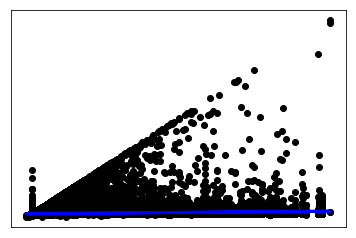

In [18]:


plt.scatter(Xtest, Ytest,  color='black')
plt.plot(Xtest, regr.predict(Xtest), color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

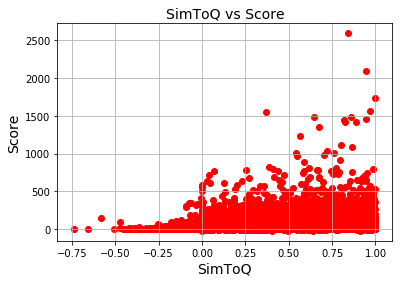

In [60]:
#'EnglishCount', 'LinkCount', 'CodeLength', 'TotalLength','Reputation','SimToQ','MaxSimToA','MinSimToA','PostOrder'
Select_feature = 'SimToQ'
plt.scatter(answers_new[Select_feature], answers_new['Score'], color='red')
plt.title(Select_feature+ ' vs Score', fontsize=14)
plt.xlabel(Select_feature, fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.grid(True)
axes = plt.gca()
#axes.set_xlim([0,2000])
plt.show()

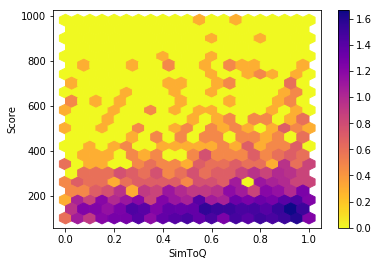

In [26]:
#'EnglishCount', 'LinkCount', 'CodeLength', 'TotalLength','Reputation','SimToQ','MaxSimToA','MinSimToA','PostOrder'
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
Select_Feature = 'SimToQ'
data_heat = pd.DataFrame(answers_new,columns = [Select_Feature,'Score']).values
#ax = sns.heatmap(data_heat)
#ax = pd.plot.hexbin(data_heat, gridsize=20)
df1 = answers_new.loc[(answers_new['Score'] >100) &(answers_new['Score'] <1000)&(answers_new[Select_Feature]>0)]
df = pd.DataFrame(df1,columns = [Select_Feature,'Score'])
ax = df.plot(x=Select_Feature, y='Score', kind = 'hexbin',gridsize=20,bins = 'log',yscale = 'linear',cmap='plasma_r',sharex=False)

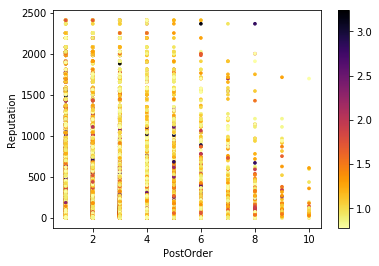

In [34]:
#'EnglishCount', 'LinkCount', 'CodeLength', 'TotalLength','Reputation','SimToQ','MaxSimToA','MinSimToA','PostOrder'

Select_Feature1 = 'PostOrder'
Select_Feature2 = 'Reputation'

df = answers_new.loc[(answers_new['Score']>5)&(answers_new['Reputation']<2500)]
df1 = pd.DataFrame(df,columns = [Select_Feature1]).values
df2 = pd.DataFrame(df,columns = [Select_Feature2]).values
df3 = pd.DataFrame(df,columns = ['Score']).values

df3 = np.log10(df3)

plt.scatter(df1, df2,\
            c=df3, cmap='inferno_r',s=7)
plt.colorbar()
plt.xlabel(Select_Feature1)
plt.ylabel(Select_Feature2)
plt.show()


In [133]:
answers_new.to_csv("answers_new_normalizedScore.csv")

In [1]:
import matplotlib.pyplot as plt
plt.scatter(Xtest, Ytest,  color='black')
plt.plot(Xtest, regr.predict(Xtest), color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

NameError: name 'Xtest' is not defined